Studying the effect of quantization on accuracy.
1. Without sampling input image see effect of quantization

[Inf] Which bit level gives us equivalent performance in BP and WP

2. With sampling input image see effect of quantization

[Inf] Which bit level gives us equivalent performance in BP and WP

3. (1) and (2) should be at same level

[Inf] Sampling input images affects performance but similarly



# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numba import njit, cuda

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Subsampling images of fashion mnist

As we need to create a look up table we need to reduce the input neuron size. Thus, we will need to sample our images

In [6]:
#creating the sample indexes
skipsinIndexes = 4
if 28%skipsinIndexes==0:
    newShape = 28//skipsinIndexes
else:
    newShape = 28//skipsinIndexes + 1
Y, X = np.meshgrid([i for i in range(0, 28, skipsinIndexes)], [i for i in range(0, 28, skipsinIndexes)])
X, Y

(array([[ 0,  0,  0,  0,  0,  0,  0],
        [ 4,  4,  4,  4,  4,  4,  4],
        [ 8,  8,  8,  8,  8,  8,  8],
        [12, 12, 12, 12, 12, 12, 12],
        [16, 16, 16, 16, 16, 16, 16],
        [20, 20, 20, 20, 20, 20, 20],
        [24, 24, 24, 24, 24, 24, 24]]),
 array([[ 0,  4,  8, 12, 16, 20, 24],
        [ 0,  4,  8, 12, 16, 20, 24],
        [ 0,  4,  8, 12, 16, 20, 24],
        [ 0,  4,  8, 12, 16, 20, 24],
        [ 0,  4,  8, 12, 16, 20, 24],
        [ 0,  4,  8, 12, 16, 20, 24],
        [ 0,  4,  8, 12, 16, 20, 24]]))

In [7]:
sampled_x_train = np.zeros(((newShape)**2, x_train.shape[1]))
sampled_x_val = np.zeros(((newShape)**2, x_val.shape[1]))
for i in range(x_train.shape[1]):
    samp = x_train[:, i].reshape((28, -1))
    sampled_x_train[:, i] = samp[X, Y].flatten()
for i in range(x_val.shape[1]):
    samp = x_val[:, i].reshape((28, -1))
    sampled_x_val[:, i] = samp[X, Y].flatten()

Text(0.5, 1.0, 'Subsampled version of the image with samples every 4 indices')

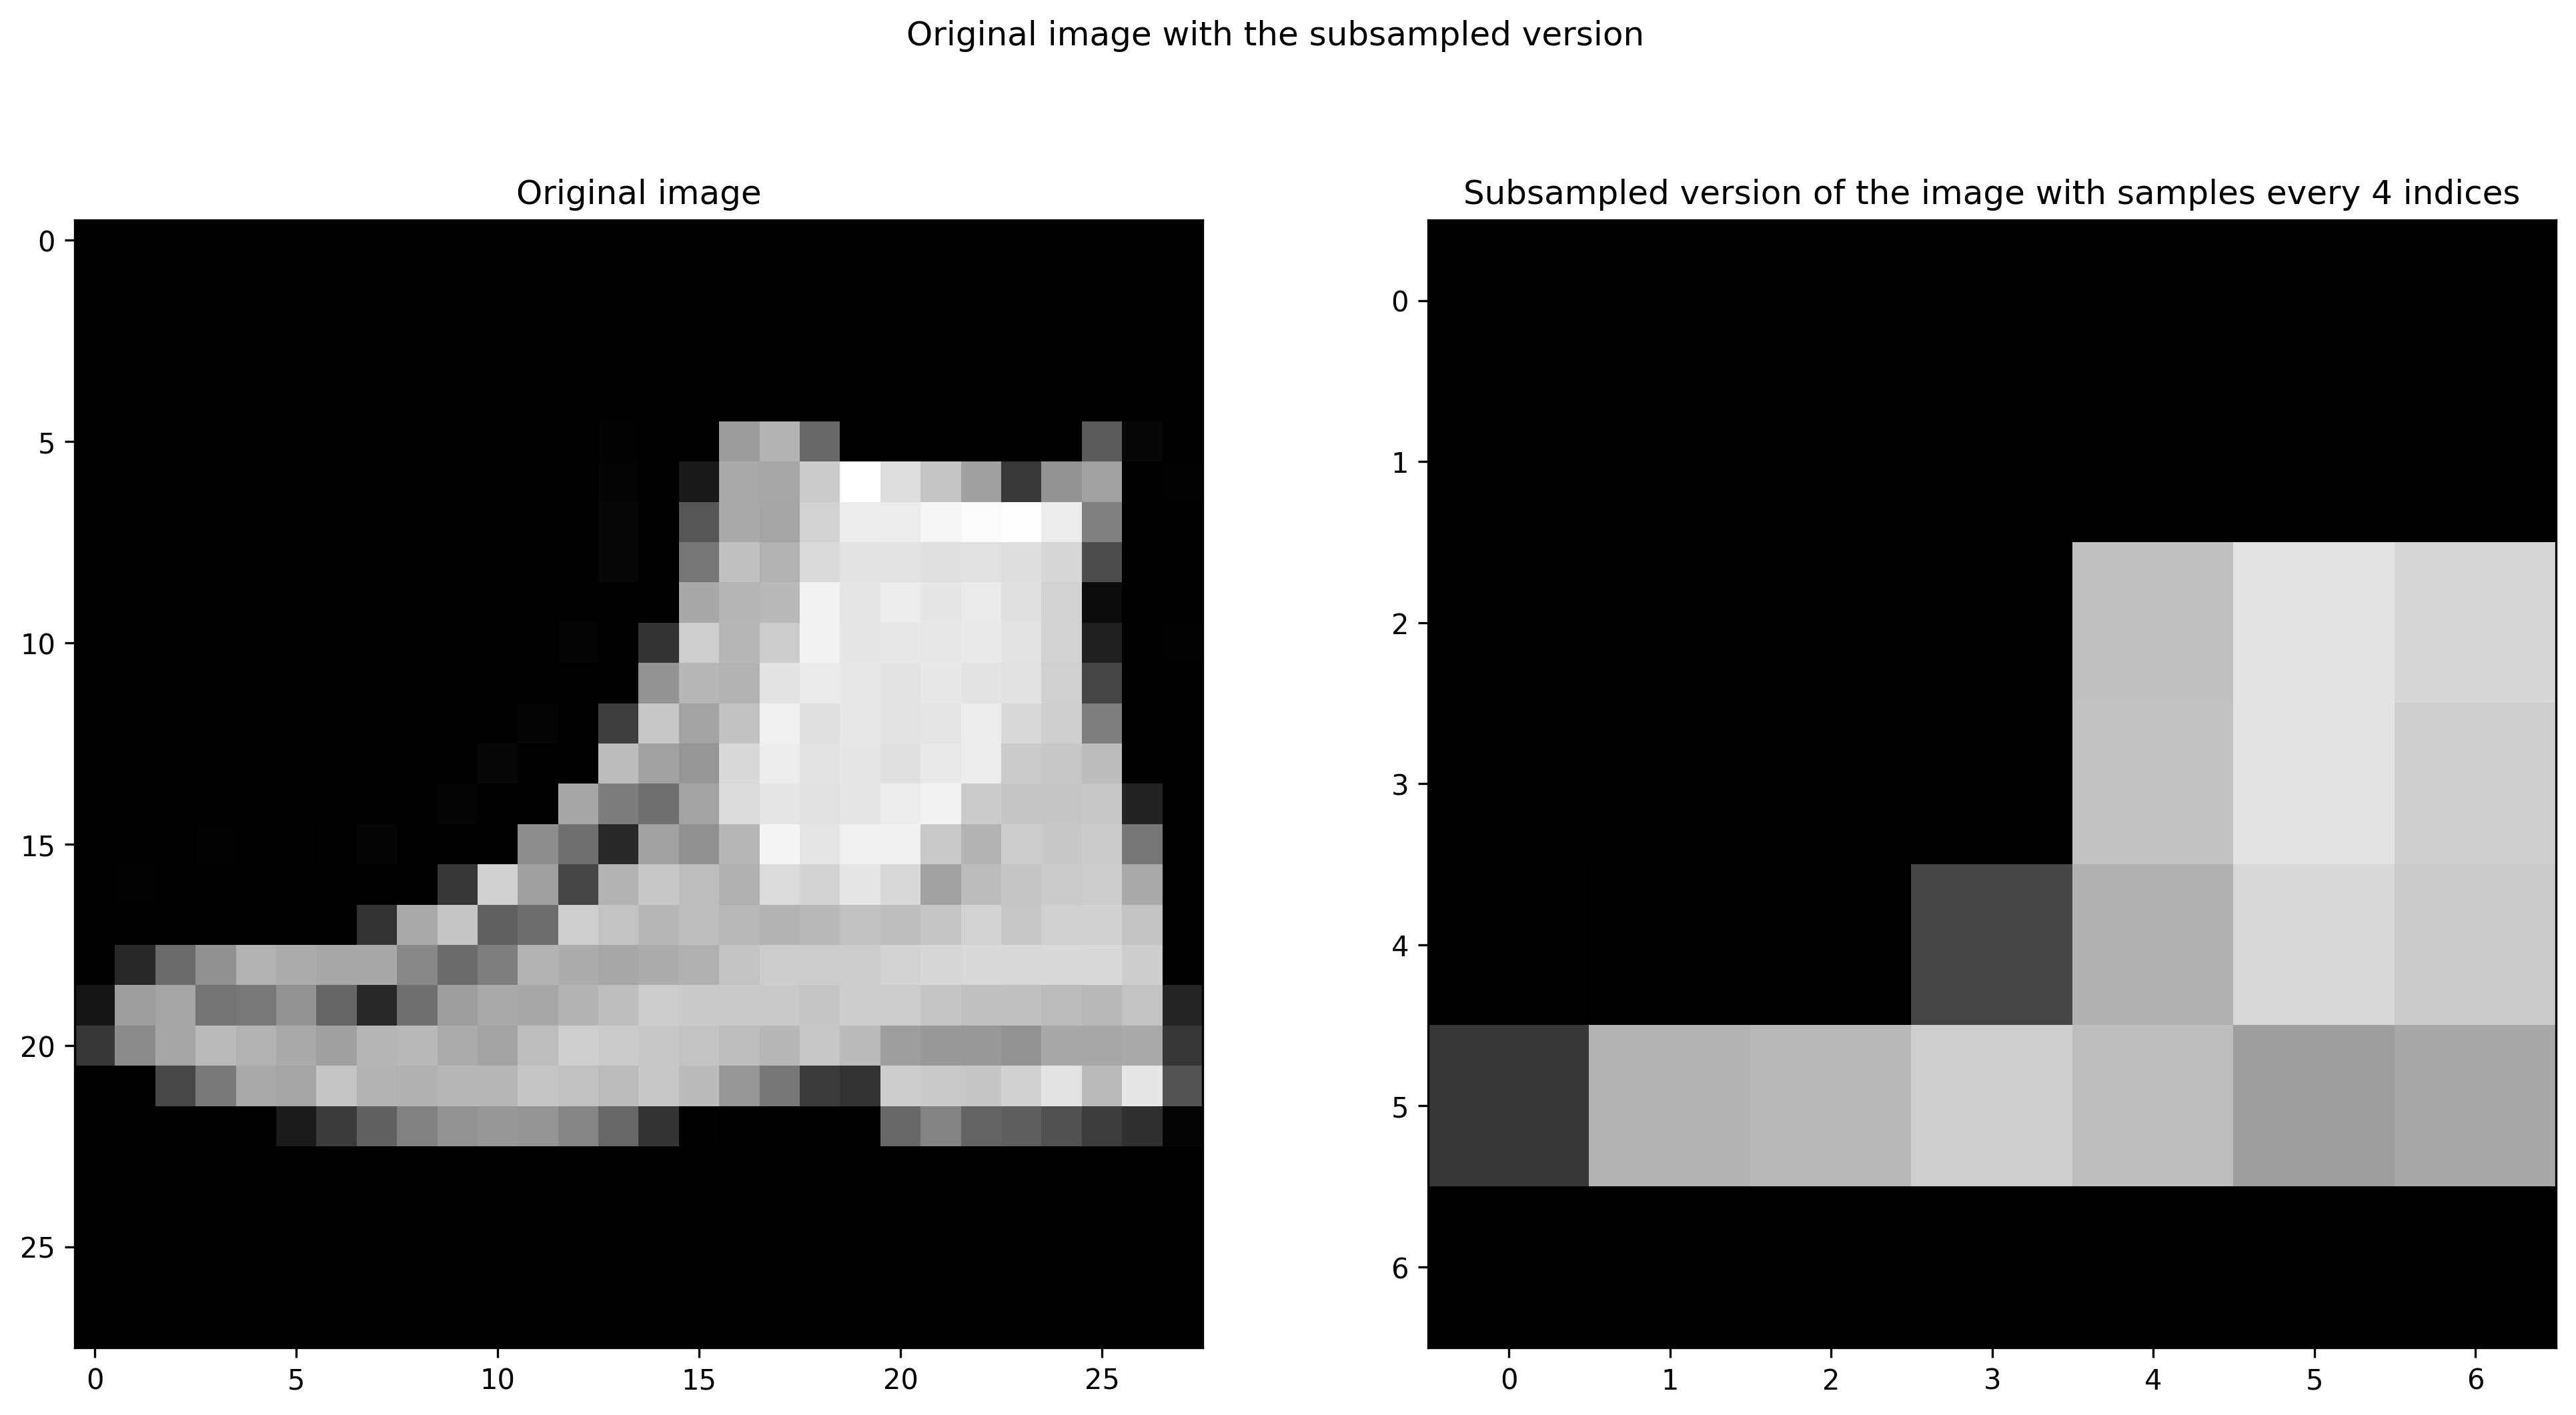

In [8]:
plt.figure(figsize = (16, 8))
plt.gcf().set_dpi(300)
ind = np.random.randint(0, x_train.shape[1])
plt.suptitle("Original image with the subsampled version")
plt.subplot(121)
plt.imshow(x_train[:, ind].reshape(28, -1), cmap = 'gray', vmin =0, vmax = 1)
plt.title("Original image")
plt.subplot(122)
plt.imshow(sampled_x_train[:, ind].reshape(newShape, -1), cmap = 'gray', vmin =0, vmax = 1)
plt.title(f"Subsampled version of the image with samples every {skipsinIndexes} indices")

# Training software BP with new subsampled version of MNIST

In [9]:
def params_init(newShape, midLayerSize, seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(midLayerSize,newShape) - 0.5
  b1 = np.random.rand(midLayerSize,1) - 0.5
  W2 = np.random.rand(10,midLayerSize) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

In [10]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [11]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre + 10e-16)), axis = 0)
  return loss

In [12]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

In [13]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

In [14]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [107]:
def batch_grad_descent(X,Y,iter, lr, midLayerSize, seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}
  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score} Val loss: {np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      # plt.figure()
      # plt.hist(W1.flatten())

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [16]:
_, _, _, _, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(sampled_x_train,y_train,iter=100, lr=0.1,midLayerSize = 10, print_op=20);

Params Initialised
Iteration: 20
Train accuracy: 69.66349206349206
Val accuracy: 69.8 Val loss: 5506.870742097963
Iteration: 40
Train accuracy: 71.2031746031746
Val accuracy: 71.25714285714285 Val loss: 5242.794202594103
Iteration: 60
Train accuracy: 72.05079365079365
Val accuracy: 72.01428571428572 Val loss: 5119.414488667126
Iteration: 80
Train accuracy: 72.57936507936508
Val accuracy: 72.58571428571429 Val loss: 5049.121859360035
Iteration: 100
Train accuracy: 72.83015873015873
Val accuracy: 72.72857142857143 Val loss: 5005.4788444707765


In [111]:
_, _, _, _, train_accBPFullImg, val_accBPFullImg, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,iter=100, lr=0.1,midLayerSize = 10, seed=47,print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 65.67142857142856
Val accuracy: 64.47142857142858 Val loss: 6653.281599688319
Iteration: 2
Train accuracy: 69.95396825396826
Val accuracy: 69.19999999999999 Val loss: 5723.207730349599
Iteration: 3
Train accuracy: 71.65079365079366
Val accuracy: 71.14285714285714 Val loss: 5342.6829474595215
Iteration: 4
Train accuracy: 72.63809523809523
Val accuracy: 72.17142857142858 Val loss: 5110.70009579257
Iteration: 5
Train accuracy: 73.4904761904762
Val accuracy: 73.12857142857143 Val loss: 4928.86631570027
Iteration: 6
Train accuracy: 74.28095238095239
Val accuracy: 74.02857142857144 Val loss: 4764.495329503856
Iteration: 7
Train accuracy: 74.98412698412699
Val accuracy: 74.7 Val loss: 4633.007240898238
Iteration: 8
Train accuracy: 75.53650793650793
Val accuracy: 75.34285714285714 Val loss: 4518.873969677319
Iteration: 9
Train accuracy: 76.11904761904762
Val accuracy: 76.0 Val loss: 4412.086344467167
Iteration: 10
Train accuracy: 76.7
Val accurac

### Generic functions related to variability

In [17]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [18]:
def initMosParam(shape, mu, sigma, vDD, precision, k=100):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/k
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    Vth[Vth<=0] = 10e-10

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((0 - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    #Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-8, size = sizeI)#no negative value
    iOff = I0Off * np.exp((0 - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)
    return (iOn, iOnNominal, iOff)

In [19]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [20]:
def createLookUpTable2d(weightArray, currents, precision, step, discreteSteps, wRange):
    dis = [(-1)*i for i in discreteSteps[::-1]] + discreteSteps
    finalLookUp = np.zeros((weightArray.shape[0], weightArray.shape[1], len(dis)))
    k = 0
    for i in dis:
        maskee = np.ones_like(weightArray, dtype = float)*i
        maskeeTransformed  = weightTransformWithVariability(maskee, currents, precision, step, discreteSteps, wRange)
        finalLookUp[:, :, k] += maskeeTransformed
        k +=1
    return finalLookUp 

In [21]:
def nearest(lookUpDiff, weightUpdate):
    # W1new = W1  - (lr*dW1)
    # we want to compare and find W1new such that |W1new-(W1  - (lr*dW1))| has least error!!!
    # We look at L1 error and take the minimum of this!
    idx = np.argmin(np.abs(lookUpDiff - weightUpdate[:,:,None]), axis = 2)
    return idx

In [22]:
def findNextWeight(lookUp, lookUpDiff, weightUpdate):
    idx = np.indices(nearest(lookUpDiff, weightUpdate).shape)
    #discrete lookup needs to be used
    return lookUp[idx[0],idx[1],nearest(lookUpDiff, weightUpdate)]

In [23]:
def findNextState(disArr, lookUpDiff, weightUpdate):
    return disArr[nearest(lookUpDiff, weightUpdate)]

In [24]:
mu = 0.7
sigma = 0.001
onoff = 10000
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 10
midLayerSize = 10
lr = 0.1

## Implementing WP

In [37]:
def WP(W1, b1, W2, b2, pert, lossBeforePert, X, y):
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pert = W1.copy()
            W1pert[i, j] += pert
            _, _, _, A2pert = forward(X, W1pert, b1, W2, b2)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)
    for i in range(b1.shape[0]):
        b1pert = b1.copy()
        b1pert[i]+=pert
        _, _, _, A2pert = forward(X, W1, b1pert, W2, b2)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pert = W2.copy()
            W2pert[i, j] += pert
            _, _, _, A2pert = forward(X, W1, b1, W2pert, b2)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)
    for i in range(b2.shape[0]):
        b2pert = b2.copy()
        b2pert[i]+=pert
        _, _, _, A2pert = forward(X, W1, b1, W2, b2pert)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

In [25]:
def WPwithVarUp(W1, b1, W2, b2, pert, lossBeforePert, X, y, precision, step, discreteSteps, wRange,  W1Var, b1Var, W2Var, b2Var, W1Currents, b1Currents, W2Currents, b2Currents):
    #assert pert==step #to get increments of '1' in the bit pattern of the weight array
    #!here we chnage perturb only one value
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    
    W1pert = W1.copy()
    W1pert += pert
    W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pertLoop = W1Var.copy()
            W1pertLoop[i, j] = W1pertArrTr[i, j]
            #print(W1pertLoop - W1Var)
            #plt.figure()
            #plt.plot(W1Var.flatten(), W1pertLoop.flatten(), '.')
            #plt.title("W1 comp")
            #do the transform only on that perturbed weight and place it in the correct place
            #W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1pertLoop, b1Var, W2Var, b2Var)
            #print(A2pert)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
            dW1[i, j] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(W1pertArrTr[i,j] - W1Var[i,j]+ 10e-16)
    #dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert
    #print(lossAfterPertW1-lossBeforePert)


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)

    b1pert = b1.copy()
    b1pert +=pert
    b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)

    for i in range(b1.shape[0]):
        b1pertLoop = b1Var.copy()
        b1pertLoop[i]=b1pertArrTr[i]
        #b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1pertLoop, W2Var, b2Var)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
        db1[i] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(b1pertArrTr[i] - b1Var[i] + 10e-16)
    #db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)

    W2pert = W2.copy()
    W2pert += pert
    W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)

    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pertLoop = W2Var.copy()
            W2pertLoop[i, j] = W2pertArrTr[i, j]
            #W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1Var, b1Var, W2pertLoop, b2Var)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
            dW2[i, j] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(W2pertArrTr[i,j] - W2Var[i,j]+ 10e-16)
    #dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert
    #print(lossAfterPertW2)


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)

    b2pert = b2.copy()
    b2pert += pert
    b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)


    for i in range(b2.shape[0]):
        b2pertLoop = b2Var.copy()
        b2pertLoop[i] = b2pertArrTr[i]
        #b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1Var, W2Var, b2pertLoop)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
        db2[i] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(b2pertArrTr[i] - b2Var[i]+ 10e-16)

    #db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

# Effect of quantization with bit level(full input image)

In [88]:
def batch_grad_descentBPWPQuantComp(X,Y,iter, pert, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  #blind updates
  W1bp = W1.copy()
  b1bp = b1.copy()
  W2bp = W2.copy()
  b2bp = b2.copy()

  #variability aware updates
  W1wp = W1.copy()
  b1wp = b1.copy()
  W2wp = W2.copy()
  b2wp = b2.copy()

  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)



  # W1lookUp = createLookUpTable2d(W1, W1Currents, precision, step, discreteSteps, wRange)
  # b1lookUp = createLookUpTable2d(b1, b1Currents, precision, step, discreteSteps, wRange)
  # W2lookUp = createLookUpTable2d(W2, W2Currents, precision, step, discreteSteps, wRange)
  # b2lookUp = createLookUpTable2d(b2, b2Currents, precision, step, discreteSteps, wRange)

  W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
  b1bp = roundArbitrary(b1bp, step, wRange)
  W2bp = roundArbitrary(W2bp, step, wRange)
  b2bp = roundArbitrary(b2bp, step, wRange)

  W1wp = roundArbitrary(W1wp, step, wRange)#weights have to maintained as their digitized versions
  b1wp = roundArbitrary(b1wp, step, wRange)
  W2wp = roundArbitrary(W2wp, step, wRange)
  b2wp = roundArbitrary(b2wp, step, wRange)


  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
      # W1varoc = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1bp, b1bp, W2bp, b2bp) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1bp, W2bp, X1, Y1)


      #W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)
      #actualW1vaUpdate = W1varoc - weightTransformWithVariability(findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1), W1Currents, precision, step, discreteSteps, wRange)
      
      # W1bp = findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1)
      # b1bp = findNextState(disArr, b1lookUp, b1varoc.reshape((midLayerSize,1)) + (-1)*lr*db1.reshape((midLayerSize,1)))
      # W2bp = findNextState(disArr, W2lookUp, W2varoc + (-1)*lr*dW2)
      # b2bp = findNextState(disArr, b2lookUp, b2varoc.reshape((10,1)) + (-1)*lr*db2.reshape((10,1)))

      W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp,b2bp, dW1, db1, dW2, db2, lr = lr)

      W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
      b1bp = roundArbitrary(b1bp, step, wRange)
      W2bp = roundArbitrary(W2bp, step, wRange)
      b2bp = roundArbitrary(b2bp, step, wRange)
      


      #blind updates
      # W1varoc = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1wp, b1wp, W2wp, b2wp) 

      loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      #dW1, db1, dW2, db2 = WP(W1, b1, W2, b2, pert=pert, lossBeforePert=loss, X=X1, y=Y1)
      #dW1, db1, dW2, db2 = WPwithVarUp(W1wp, b1wp, W2wp, b2wp, pert, loss, X1, Y1, precision, step, discreteSteps, wRange,  W1varoc, b1varoc, W2varoc, b2varoc, W1Currents, b1Currents, W2Currents, b2Currents)

      dW1, db1, dW2, db2 = WP(W1wp, b1wp, W2wp, b2wp, pert, loss, X1, Y1)
      # W1wp = findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1)
      # b1wp = findNextState(disArr, b1lookUp, b1varoc.reshape((midLayerSize,1)) + (-1)*lr*db1.reshape((midLayerSize,1)))
      # W2wp = findNextState(disArr, W2lookUp, W2varoc + (-1)*lr*dW2)
      # b2wp = findNextState(disArr, b2lookUp, b2varoc.reshape((10,1)) + (-1)*lr*db2.reshape((10,1)))

      W1wp, b1wp, W2wp, b2wp = param_update(W1wp, b1wp, W2wp,b2wp, dW1, db1, dW2, db2, lr = lr)

      W1wp = roundArbitrary(W1wp, step, wRange)#weights have to maintained as their digitized versions
      b1wp = roundArbitrary(b1wp, step, wRange)
      W2wp = roundArbitrary(W2wp, step, wRange)
      b2wp = roundArbitrary(b2wp, step, wRange)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      # W1varoc = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1bp, b1bp, W2bp, b2bp)
      _, _, _,   A2_val = forward(sampled_x_val, W1bp, b1bp, W2bp, b2bp)
      buAccTrainAcc = accuracy(predictions(A2_train), Y)
      buTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      buAccValAcc = accuracy(predictions(A2_val), y_val)
      buValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


      # W1varoc = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1wp, b1wp, W2wp, b2wp)
      _, _, _,   A2_val = forward(sampled_x_val, W1wp, b1wp, W2wp, b2wp)
      vaAccTrainAcc = accuracy(predictions(A2_train), Y)
      vaTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      vaAccValAcc = accuracy(predictions(A2_val), y_val)
      vaValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))
  
      train_acc.append([buAccTrainAcc, vaAccTrainAcc])
      print(f'Training :: BP : {buAccTrainAcc} :: WP : {vaAccTrainAcc}')


      val_acc.append([buAccValAcc, vaAccTrainAcc])
      print(f'Validation  :: BP : {buAccValAcc} :: WP : {vaAccValAcc} :: Blind Loss : {buValLoss} :: Val Loss : {vaValLoss}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


## Sampled Image training effect of quantization

In [58]:
mu = 0.7
#sigma = 0.01
sigma = 0.000000000000000000001
onoff = 100000000000000000000000
vDD = 5
precision = 8#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10
lr = 0.1

In [59]:
finTrainAcc = []
finValAcc = []
for precision in [2,4,6,8,10, 12, 14, 16]:
    wRange = 1
    noOfLevels = 2**precision - 1 #no of levels of quantization
    #step = round(wRange/noOfLevels, precision)
    step =  wRange/noOfLevels#step size of each of the step after quantization
    #discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
    discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
    _, _, _, _, train_acc, val_acc, _, _, _ = batch_grad_descentBPWPQuantComp(sampled_x_train,y_train,iter, step, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = 47,print_op=1)
    finTrainAcc.append(train_acc)
    finValAcc.append(val_acc)

Params Initialised
Iteration: 1
Training :: BP : 10.46984126984127 :: WP : 10.46984126984127
Validation  :: BP : 11.085714285714285 :: WP : 11.085714285714285 :: Blind Loss : 17203.78839059948 :: Val Loss : 17203.78839059948
Iteration: 2
Training :: BP : 10.46984126984127 :: WP : 10.46984126984127
Validation  :: BP : 11.085714285714285 :: WP : 11.085714285714285 :: Blind Loss : 17203.78839059948 :: Val Loss : 17203.78839059948
Iteration: 3
Training :: BP : 10.46984126984127 :: WP : 10.46984126984127
Validation  :: BP : 11.085714285714285 :: WP : 11.085714285714285 :: Blind Loss : 17203.78839059948 :: Val Loss : 17203.78839059948
Iteration: 4
Training :: BP : 10.46984126984127 :: WP : 10.46984126984127
Validation  :: BP : 11.085714285714285 :: WP : 11.085714285714285 :: Blind Loss : 17203.78839059948 :: Val Loss : 17203.78839059948
Iteration: 5
Training :: BP : 10.46984126984127 :: WP : 10.46984126984127
Validation  :: BP : 11.085714285714285 :: WP : 11.085714285714285 :: Blind Loss : 1

In [60]:
finTrainAcc

[[[10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.469841269

finTrainAcc = [[[10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127],
  [10.46984126984127, 10.46984126984127]],
 [[11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428],
  [11.628571428571428, 11.628571428571428]],
 [[16.823809523809523, 16.915873015873014],
  [16.466666666666665, 16.506349206349206],
  [16.273015873015872, 16.04285714285714],
  [16.284126984126985, 15.980952380952381],
  [16.334920634920636, 16.255555555555556],
  [16.1984126984127, 16.26825396825397],
  [16.49047619047619, 16.57142857142857],
  [16.957142857142856, 16.853968253968254],
  [17.230158730158728, 16.915873015873014],
  [17.195238095238093, 17.168253968253968],
  [17.204761904761906, 17.155555555555555],
  [17.212698412698412, 17.16984126984127],
  [17.223809523809525, 17.174603174603178],
  [17.233333333333334, 17.184126984126983],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619],
  [17.233333333333334, 17.19047619047619]],
 [[43.51904761904762, 43.439682539682536],
  [54.18253968253969, 54.147619047619045],
  [56.666666666666664, 56.677777777777784],
  [58.579365079365076, 58.561904761904756],
  [59.52063492063492, 59.78253968253968],
  [60.53492063492063, 60.79682539682539],
  [61.57142857142858, 61.75396825396825],
  [62.29523809523809, 62.541269841269845],
  [62.958730158730155, 63.13809523809524],
  [63.51587301587301, 63.7],
  [63.87460317460317, 64.10317460317461],
  [64.25714285714285, 64.42539682539683],
  [64.52698412698412, 64.66984126984127],
  [64.72063492063492, 64.87142857142857],
  [64.85238095238095, 65.04603174603174],
  [65.06666666666666, 65.23809523809524],
  [65.21746031746032, 65.35873015873015],
  [65.29523809523809, 65.5063492063492],
  [65.45873015873016, 65.63333333333333],
  [65.54761904761904, 65.73492063492064],
  [65.58571428571427, 65.84444444444445],
  [65.70793650793651, 65.97777777777777],
  [65.76190476190476, 65.95555555555556],
  [65.83015873015873, 66.03174603174602],
  [65.85396825396825, 66.08888888888889],
  [65.88253968253969, 66.12698412698413],
  [65.92380952380952, 66.23015873015873],
  [65.96507936507936, 66.31428571428572],
  [66.03968253968254, 66.35714285714286],
  [66.0984126984127, 66.44920634920635],
  [66.21428571428571, 66.53650793650795],
  [66.16507936507936, 66.56507936507936],
  [66.2984126984127, 66.63650793650794],
  [66.33809523809524, 66.73333333333333],
  [66.36984126984127, 66.76666666666667],
  [66.3984126984127, 66.73492063492064],
  [66.36825396825397, 66.8111111111111],
  [66.37301587301587, 66.84761904761905],
  [66.42222222222223, 66.85238095238095],
  [66.42857142857143, 66.88730158730158],
  [66.46507936507936, 66.91587301587302],
  [66.48412698412697, 66.89206349206349],
  [66.4968253968254, 66.8952380952381],
  [66.51269841269841, 66.94920634920635],
  [66.49047619047619, 66.97619047619048],
  [66.54444444444444, 67.01269841269841],
  [66.56507936507936, 66.98571428571428],
  [66.59206349206349, 67.02857142857142],
  [66.61587301587302, 67.03333333333333],
  [66.6047619047619, 67.03492063492064],
  [66.61428571428571, 67.04126984126985],
  [66.7063492063492, 67.01587301587301],
  [66.74920634920635, 67.11746031746031],
  [66.72857142857143, 67.05555555555556],
  [66.78095238095239, 67.08253968253969],
  [66.76507936507936, 67.14126984126985],
  [66.84126984126985, 67.14761904761905],
  [66.82380952380952, 67.0904761904762],
  [66.85714285714286, 67.10000000000001],
  [66.9063492063492, 67.11587301587302],
  [66.86825396825397, 67.12539682539682],
  [66.88412698412698, 67.17460317460318],
  [66.91904761904762, 67.13492063492063],
  [66.96666666666667, 67.02063492063492],
  [66.96507936507936, 66.91428571428571],
  [66.95873015873016, 66.88253968253969],
  [66.88412698412698, 67.0047619047619],
  [67.02063492063492, 66.97460317460317],
  [67.0111111111111, 66.85555555555555],
  [67.01269841269841, 66.84920634920634],
  [67.03968253968254, 66.97777777777777],
  [67.11111111111111, 67.02698412698412],
  [66.88888888888889, 66.89047619047619],
  [66.92857142857143, 66.91904761904762],
  [66.94761904761904, 66.77301587301588],
  [66.97142857142858, 66.79206349206349],
  [66.95555555555556, 66.8015873015873],
  [66.94761904761904, 66.83333333333333],
  [66.95873015873016, 66.7095238095238],
  [66.83015873015873, 66.75555555555556],
  [66.94603174603174, 66.67301587301587],
  [66.92380952380952, 66.67142857142856],
  [66.97777777777777, 66.5936507936508],
  [66.97777777777777, 66.64603174603174],
  [67.07936507936509, 66.64126984126985],
  [67.0936507936508, 66.60952380952381],
  [66.94761904761904, 66.65714285714286],
  [67.07460317460317, 66.67142857142856],
  [67.03333333333333, 66.72698412698412],
  [67.04444444444444, 66.73968253968255],
  [67.00952380952381, 66.78412698412698],
  [67.0111111111111, 66.82857142857142],
  [66.9936507936508, 66.75238095238095],
  [67.03015873015873, 66.88571428571429],
  [67.01904761904763, 66.76984126984127],
  [66.96984126984127, 66.82222222222222],
  [67.02539682539683, 66.90158730158731],
  [67.13174603174603, 66.79206349206349],
  [67.10000000000001, 66.9047619047619],
  [67.08888888888889, 66.85873015873017]],
 [[48.67619047619048, 48.69206349206349],
  [59.61904761904761, 59.611111111111114],
  [62.50634920634921, 62.48412698412699],
  [63.86507936507937, 63.89523809523809],
  [64.94920634920635, 64.96349206349207],
  [65.79206349206349, 65.78412698412698],
  [66.41428571428571, 66.43809523809524],
  [66.96031746031747, 66.9936507936508],
  [67.36190476190477, 67.43333333333334],
  [67.66666666666666, 67.72698412698412],
  [67.9015873015873, 67.95238095238095],
  [68.09206349206349, 68.12222222222222],
  [68.2984126984127, 68.2968253968254],
  [68.4888888888889, 68.53650793650795],
  [68.56825396825397, 68.61746031746033],
  [68.64444444444445, 68.66190476190475],
  [68.76190476190476, 68.77936507936508],
  [68.88730158730158, 68.87936507936509],
  [68.95238095238095, 68.98253968253968],
  [68.99047619047619, 69.04285714285714],
  [69.02539682539683, 69.08888888888889],
  [69.12380952380953, 69.18888888888888],
  [69.1968253968254, 69.25873015873016],
  [69.25396825396825, 69.32380952380952],
  [69.28888888888889, 69.39047619047619],
  [69.35238095238095, 69.5063492063492],
  [69.41904761904762, 69.55079365079365],
  [69.47460317460317, 69.59206349206349],
  [69.5031746031746, 69.65714285714286],
  [69.51269841269841, 69.71111111111111],
  [69.55238095238096, 69.73650793650793],
  [69.61428571428571, 69.76825396825397],
  [69.63015873015873, 69.80634920634921],
  [69.69841269841271, 69.83968253968254],
  [69.72857142857143, 69.88412698412698],
  [69.76984126984127, 69.89047619047619],
  [69.83333333333334, 69.92698412698412],
  [69.86507936507937, 69.95714285714286],
  [69.88412698412698, 69.9984126984127],
  [69.94126984126984, 70.04285714285714],
  [69.94444444444444, 70.04920634920634],
  [70.0047619047619, 70.06984126984128],
  [70.04285714285714, 70.0952380952381],
  [70.04920634920634, 70.12698412698413],
  [70.08095238095238, 70.13809523809523],
  [70.10634920634921, 70.09841269841269],
  [70.14444444444445, 70.11904761904762],
  [70.15714285714286, 70.15873015873015],
  [70.16666666666667, 70.18095238095238],
  [70.1968253968254, 70.22539682539683],
  [70.21428571428572, 70.25396825396825],
  [70.23174603174603, 70.3015873015873],
  [70.26190476190476, 70.31746031746032],
  [70.24444444444444, 70.34285714285714],
  [70.26825396825397, 70.34285714285714],
  [70.28730158730158, 70.38412698412698],
  [70.28571428571428, 70.3952380952381],
  [70.3047619047619, 70.41111111111111],
  [70.31587301587302, 70.48412698412699],
  [70.32857142857142, 70.50952380952381],
  [70.33492063492064, 70.53650793650795],
  [70.34603174603174, 70.53968253968253],
  [70.36190476190475, 70.5936507936508],
  [70.38412698412698, 70.6],
  [70.4031746031746, 70.5936507936508],
  [70.42222222222222, 70.58730158730158],
  [70.4095238095238, 70.62222222222222],
  [70.42222222222222, 70.62380952380953],
  [70.44761904761904, 70.65238095238095],
  [70.45873015873015, 70.65238095238095],
  [70.4888888888889, 70.66031746031746],
  [70.48730158730159, 70.68253968253968],
  [70.48730158730159, 70.69047619047619],
  [70.5063492063492, 70.71269841269842],
  [70.54285714285714, 70.71746031746031],
  [70.55079365079365, 70.7015873015873],
  [70.55396825396826, 70.73174603174604],
  [70.56666666666666, 70.71746031746031],
  [70.56666666666666, 70.73968253968253],
  [70.60317460317461, 70.74920634920635],
  [70.62380952380953, 70.73174603174604],
  [70.62539682539682, 70.77936507936508],
  [70.64761904761905, 70.82380952380952],
  [70.64920634920635, 70.83015873015873],
  [70.64444444444445, 70.83809523809524],
  [70.66507936507936, 70.83968253968254],
  [70.68253968253968, 70.86349206349206],
  [70.68571428571428, 70.87460317460318],
  [70.71111111111111, 70.85714285714285],
  [70.7, 70.89999999999999],
  [70.72380952380952, 70.9047619047619],
  [70.73015873015873, 70.91746031746031],
  [70.76349206349207, 70.91746031746031],
  [70.76031746031745, 70.93809523809523],
  [70.76031746031745, 70.94126984126984],
  [70.77301587301588, 70.96190476190476],
  [70.77619047619048, 70.95238095238095],
  [70.7936507936508, 70.98571428571428],
  [70.8047619047619, 70.9888888888889],
  [70.8079365079365, 70.96825396825398]],
 [[48.68412698412698, 48.68412698412698],
  [59.62222222222222, 59.609523809523814],
  [62.541269841269845, 62.541269841269845],
  [63.97301587301587, 63.96349206349207],
  [65.03650793650793, 65.03492063492064],
  [65.89047619047619, 65.9095238095238],
  [66.56666666666666, 66.56825396825397],
  [67.0952380952381, 67.1047619047619],
  [67.53333333333333, 67.57142857142857],
  [67.83174603174604, 67.83968253968254],
  [68.13015873015873, 68.13492063492063],
  [68.32222222222222, 68.32698412698413],
  [68.4888888888889, 68.49047619047619],
  [68.66190476190475, 68.66507936507936],
  [68.79206349206349, 68.7968253968254],
  [68.84126984126983, 68.88412698412698],
  [68.94603174603175, 68.98095238095237],
  [69.06507936507936, 69.06190476190476],
  [69.17777777777778, 69.18571428571428],
  [69.23809523809524, 69.25714285714287],
  [69.33333333333334, 69.35714285714286],
  [69.41269841269842, 69.44126984126984],
  [69.5031746031746, 69.53650793650795],
  [69.58730158730158, 69.62222222222222],
  [69.63015873015873, 69.67301587301587],
  [69.70952380952382, 69.75079365079365],
  [69.7936507936508, 69.81746031746032],
  [69.83492063492064, 69.86984126984127],
  [69.89047619047619, 69.91269841269842],
  [69.93650793650794, 69.96190476190476],
  [69.98571428571428, 69.9984126984127],
  [70.02380952380952, 70.02222222222223],
  [70.06349206349206, 70.07142857142857],
  [70.12539682539682, 70.13492063492063],
  [70.16666666666667, 70.18730158730159],
  [70.18888888888888, 70.21587301587302],
  [70.22222222222221, 70.25555555555556],
  [70.26031746031745, 70.2936507936508],
  [70.3047619047619, 70.33650793650794],
  [70.32857142857142, 70.36349206349206],
  [70.34920634920636, 70.37460317460318],
  [70.38412698412698, 70.4031746031746],
  [70.41111111111111, 70.44603174603175],
  [70.43968253968254, 70.46031746031746],
  [70.44285714285714, 70.47460317460317],
  [70.45079365079366, 70.4984126984127],
  [70.46349206349205, 70.49047619047619],
  [70.47301587301588, 70.52380952380952],
  [70.51428571428572, 70.56984126984128],
  [70.54761904761905, 70.6047619047619],
  [70.6015873015873, 70.64761904761905],
  [70.64444444444445, 70.6936507936508],
  [70.67777777777778, 70.73015873015873],
  [70.71111111111111, 70.76031746031745],
  [70.76190476190476, 70.81904761904761],
  [70.78253968253968, 70.83492063492064],
  [70.82539682539682, 70.85873015873015],
  [70.86190476190475, 70.87460317460318],
  [70.88571428571429, 70.92063492063491],
  [70.89999999999999, 70.95079365079366],
  [70.92222222222222, 70.96190476190476],
  [70.96031746031746, 70.98412698412699],
  [70.98412698412699, 71.02222222222223],
  [71.02222222222223, 71.04285714285714],
  [71.04761904761905, 71.06984126984128],
  [71.06984126984128, 71.10317460317461],
  [71.1015873015873, 71.13650793650793],
  [71.12539682539682, 71.17142857142858],
  [71.14920634920635, 71.18412698412698],
  [71.15396825396826, 71.2],
  [71.17460317460318, 71.23492063492064],
  [71.18571428571428, 71.24126984126984],
  [71.21428571428572, 71.25873015873016],
  [71.22063492063492, 71.26666666666667],
  [71.25238095238096, 71.27619047619046],
  [71.24603174603175, 71.2904761904762],
  [71.28888888888889, 71.31111111111112],
  [71.31746031746032, 71.33174603174604],
  [71.32857142857144, 71.35396825396826],
  [71.36984126984127, 71.36825396825397],
  [71.38095238095238, 71.4047619047619],
  [71.36825396825397, 71.38412698412698],
  [71.37301587301587, 71.38412698412698],
  [71.38095238095238, 71.4063492063492],
  [71.3873015873016, 71.41904761904762],
  [71.41746031746031, 71.42380952380952],
  [71.43174603174603, 71.44603174603175],
  [71.46825396825398, 71.46666666666667],
  [71.45873015873015, 71.48412698412699],
  [71.48253968253968, 71.5047619047619],
  [71.49523809523811, 71.51746031746032],
  [71.4936507936508, 71.51269841269841],
  [71.50634920634921, 71.53809523809524],
  [71.50952380952381, 71.56666666666666],
  [71.53015873015873, 71.57460317460318],
  [71.53174603174604, 71.5952380952381],
  [71.54285714285714, 71.63015873015873],
  [71.57301587301588, 71.62857142857143],
  [71.57301587301588, 71.63015873015873],
  [71.56984126984128, 71.63492063492065]],
 [[48.717460317460315, 48.72222222222222],
  [59.612698412698414, 59.615873015873014],
  [62.560317460317464, 62.55714285714286],
  [63.98095238095238, 63.977777777777774],
  [65.05396825396825, 65.05396825396825],
  [65.88888888888889, 65.89682539682539],
  [66.54920634920634, 66.55873015873016],
  [67.0936507936508, 67.08730158730158],
  [67.52857142857142, 67.52222222222221],
  [67.85396825396826, 67.85873015873017],
  [68.10634920634921, 68.12698412698413],
  [68.34603174603174, 68.33968253968254],
  [68.49841269841271, 68.51428571428572],
  [68.66507936507936, 68.66984126984127],
  [68.77777777777779, 68.78571428571428],
  [68.87936507936509, 68.87460317460318],
  [68.94761904761904, 68.96666666666667],
  [69.07619047619048, 69.06507936507936],
  [69.18412698412698, 69.18730158730159],
  [69.26190476190476, 69.25873015873016],
  [69.34761904761905, 69.34920634920636],
  [69.43174603174603, 69.43492063492064],
  [69.52063492063492, 69.52222222222221],
  [69.6079365079365, 69.62222222222222],
  [69.65873015873015, 69.66349206349206],
  [69.71587301587302, 69.72857142857143],
  [69.79206349206349, 69.8],
  [69.85873015873015, 69.86666666666666],
  [69.9015873015873, 69.89999999999999],
  [69.94920634920635, 69.94603174603175],
  [70.0079365079365, 69.9984126984127],
  [70.05079365079365, 70.06031746031745],
  [70.1047619047619, 70.12063492063491],
  [70.16031746031746, 70.16190476190476],
  [70.1968253968254, 70.1984126984127],
  [70.23650793650795, 70.22380952380952],
  [70.26984126984127, 70.27777777777777],
  [70.32063492063492, 70.32222222222222],
  [70.36190476190475, 70.35238095238095],
  [70.37619047619049, 70.38253968253969],
  [70.4063492063492, 70.41428571428571],
  [70.43809523809523, 70.44126984126984],
  [70.44444444444444, 70.44920634920635],
  [70.46825396825398, 70.47460317460317],
  [70.48412698412699, 70.48253968253968],
  [70.5047619047619, 70.4984126984127],
  [70.53492063492064, 70.51904761904761],
  [70.55555555555556, 70.55396825396826],
  [70.5936507936508, 70.58730158730158],
  [70.60634920634921, 70.62539682539682],
  [70.65714285714286, 70.67142857142858],
  [70.7031746031746, 70.71746031746031],
  [70.74603174603175, 70.74603174603175],
  [70.76984126984127, 70.7968253968254],
  [70.8015873015873, 70.81111111111112],
  [70.82063492063492, 70.85079365079365],
  [70.86666666666666, 70.88571428571429],
  [70.9063492063492, 70.9047619047619],
  [70.93174603174603, 70.92539682539683],
  [70.96349206349205, 70.96031746031746],
  [70.99682539682539, 71.0079365079365],
  [71.01746031746032, 71.03650793650793],
  [71.06507936507937, 71.08888888888889],
  [71.11269841269842, 71.13968253968254],
  [71.14761904761905, 71.17301587301587],
  [71.16984126984127, 71.18571428571428],
  [71.19047619047619, 71.22222222222221],
  [71.21587301587302, 71.23174603174604],
  [71.23650793650793, 71.25079365079365],
  [71.26825396825397, 71.25238095238096],
  [71.28571428571429, 71.28730158730158],
  [71.28888888888889, 71.31904761904761],
  [71.31428571428572, 71.32698412698413],
  [71.32539682539682, 71.33015873015873],
  [71.33492063492064, 71.33968253968254],
  [71.34444444444445, 71.35079365079365],
  [71.36825396825397, 71.38571428571429],
  [71.38412698412698, 71.4015873015873],
  [71.39999999999999, 71.43333333333334],
  [71.41904761904762, 71.43650793650794],
  [71.43492063492064, 71.45555555555556],
  [71.44285714285714, 71.48095238095237],
  [71.46825396825398, 71.48412698412699],
  [71.49682539682539, 71.50158730158729],
  [71.50158730158729, 71.5079365079365],
  [71.51269841269841, 71.53809523809524],
  [71.53968253968253, 71.55238095238096],
  [71.55873015873016, 71.55873015873016],
  [71.56349206349206, 71.57460317460318],
  [71.56666666666666, 71.56825396825397],
  [71.56984126984128, 71.58412698412698],
  [71.57142857142857, 71.58412698412698],
  [71.57936507936508, 71.61269841269842],
  [71.60793650793651, 71.60793650793651],
  [71.61111111111111, 71.62380952380953],
  [71.64285714285714, 71.63650793650793],
  [71.63174603174603, 71.64920634920635],
  [71.64285714285714, 71.66190476190476],
  [71.66031746031746, 71.6936507936508],
  [71.68730158730159, 71.70952380952382]],
 [[48.71111111111111, 48.70952380952381],
  [59.61904761904761, 59.61746031746031],
  [62.56507936507937, 62.56190476190476],
  [63.98888888888889, 63.98888888888889],
  [65.05396825396825, 65.05396825396825],
  [65.8952380952381, 65.89206349206349],
  [66.56666666666666, 66.56190476190477],
  [67.09206349206349, 67.08730158730158],
  [67.52222222222221, 67.53015873015873],
  [67.86190476190475, 67.86349206349206],
  [68.12539682539682, 68.12698412698413],
  [68.34603174603174, 68.35079365079365],
  [68.5111111111111, 68.5079365079365],
  [68.66507936507936, 68.66666666666667],
  [68.77777777777779, 68.77777777777779],
  [68.87460317460318, 68.88095238095238],
  [68.96031746031746, 68.95873015873016],
  [69.06984126984128, 69.06984126984128],
  [69.19047619047619, 69.18888888888888],
  [69.25555555555556, 69.24920634920635],
  [69.34761904761905, 69.35079365079365],
  [69.43650793650794, 69.44126984126984],
  [69.53015873015873, 69.52857142857142],
  [69.61269841269842, 69.61746031746033],
  [69.65873015873015, 69.65396825396826],
  [69.71269841269842, 69.71269841269842],
  [69.8, 69.79841269841269],
  [69.86666666666666, 69.86825396825397],
  [69.91111111111111, 69.91428571428571],
  [69.95873015873015, 69.96349206349205],
  [70.01111111111112, 70.01111111111112],
  [70.05873015873016, 70.05555555555556],
  [70.11428571428571, 70.11269841269842],
  [70.15873015873015, 70.15873015873015],
  [70.1936507936508, 70.1984126984127],
  [70.23333333333333, 70.24126984126984],
  [70.26984126984127, 70.27936507936508],
  [70.32380952380952, 70.32539682539682],
  [70.36190476190475, 70.36507936507937],
  [70.37777777777777, 70.38095238095238],
  [70.4063492063492, 70.4063492063492],
  [70.44285714285714, 70.45079365079366],
  [70.44126984126984, 70.44444444444444],
  [70.46349206349205, 70.46984126984127],
  [70.4936507936508, 70.4888888888889],
  [70.4984126984127, 70.4952380952381],
  [70.52539682539683, 70.52698412698413],
  [70.55873015873016, 70.55714285714285],
  [70.5936507936508, 70.58571428571429],
  [70.6, 70.60793650793651],
  [70.67619047619048, 70.67142857142858],
  [70.7, 70.6936507936508],
  [70.75079365079365, 70.73968253968253],
  [70.77142857142857, 70.76825396825397],
  [70.8079365079365, 70.80634920634921],
  [70.83809523809524, 70.83492063492064],
  [70.86984126984127, 70.87777777777777],
  [70.91428571428573, 70.91904761904762],
  [70.95079365079366, 70.95555555555556],
  [70.97936507936508, 70.98095238095237],
  [71.02380952380952, 71.02857142857142],
  [71.04126984126984, 71.03809523809524],
  [71.0904761904762, 71.08888888888889],
  [71.11269841269842, 71.12539682539682],
  [71.15079365079366, 71.15396825396826],
  [71.17619047619047, 71.18571428571428],
  [71.19682539682539, 71.21111111111111],
  [71.21904761904761, 71.22698412698412],
  [71.24126984126984, 71.25079365079365],
  [71.27301587301588, 71.27619047619046],
  [71.28888888888889, 71.28888888888889],
  [71.31428571428572, 71.31904761904761],
  [71.33650793650793, 71.34444444444445],
  [71.35396825396826, 71.35396825396826],
  [71.36031746031746, 71.35396825396826],
  [71.35396825396826, 71.36349206349206],
  [71.39047619047619, 71.3873015873016],
  [71.4047619047619, 71.41111111111111],
  [71.41428571428573, 71.42222222222222],
  [71.42539682539683, 71.42380952380952],
  [71.43809523809523, 71.44603174603175],
  [71.47460317460317, 71.47777777777777],
  [71.49523809523811, 71.5047619047619],
  [71.50952380952381, 71.51269841269841],
  [71.52857142857142, 71.53333333333333],
  [71.53650793650793, 71.54285714285714],
  [71.54761904761905, 71.55714285714285],
  [71.56507936507937, 71.57619047619048],
  [71.57301587301588, 71.57619047619048],
  [71.59841269841269, 71.6],
  [71.58888888888889, 71.5904761904762],
  [71.59841269841269, 71.6],
  [71.60317460317461, 71.61904761904762],
  [71.62222222222222, 71.61428571428571],
  [71.62222222222222, 71.61904761904762],
  [71.64126984126983, 71.63809523809523],
  [71.66507936507936, 71.66190476190476],
  [71.67460317460318, 71.67460317460318],
  [71.68730158730159, 71.7],
  [71.7, 71.7]]]

In [86]:
_, _, _, _, train_accBPSoftWare, val_accBPSoftWare, train_loss, val_loss, sum_weights = batch_grad_descent(sampled_x_train,y_train,iter=100, lr=0.1,midLayerSize = 10, seed = 47, print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 48.70793650793651
Val accuracy: 48.699999999999996 Val loss: 10577.097088385068
Iteration: 2
Train accuracy: 59.66825396825397
Val accuracy: 59.44285714285714 Val loss: 8261.065889620535
Iteration: 3
Train accuracy: 62.67936507936508
Val accuracy: 62.18571428571429 Val loss: 7339.208350671162
Iteration: 4
Train accuracy: 64.33333333333333
Val accuracy: 64.05714285714285 Val loss: 6833.864444437306
Iteration: 5
Train accuracy: 65.38730158730158
Val accuracy: 65.01428571428572 Val loss: 6516.888877608058
Iteration: 6
Train accuracy: 66.16825396825396
Val accuracy: 65.87142857142857 Val loss: 6302.4624171583955
Iteration: 7
Train accuracy: 66.88571428571429
Val accuracy: 66.55714285714286 Val loss: 6149.032169939272
Iteration: 8
Train accuracy: 67.3063492063492
Val accuracy: 67.07142857142857 Val loss: 6033.547416257465
Iteration: 9
Train accuracy: 67.73968253968255
Val accuracy: 67.37142857142857 Val loss: 5943.327176612776
Iteration: 10
Tr

Text(0.5, 1.0, 'Accuracy vs Epochs (Training) - Subsampled Input image(28x28 -> 7x7)')

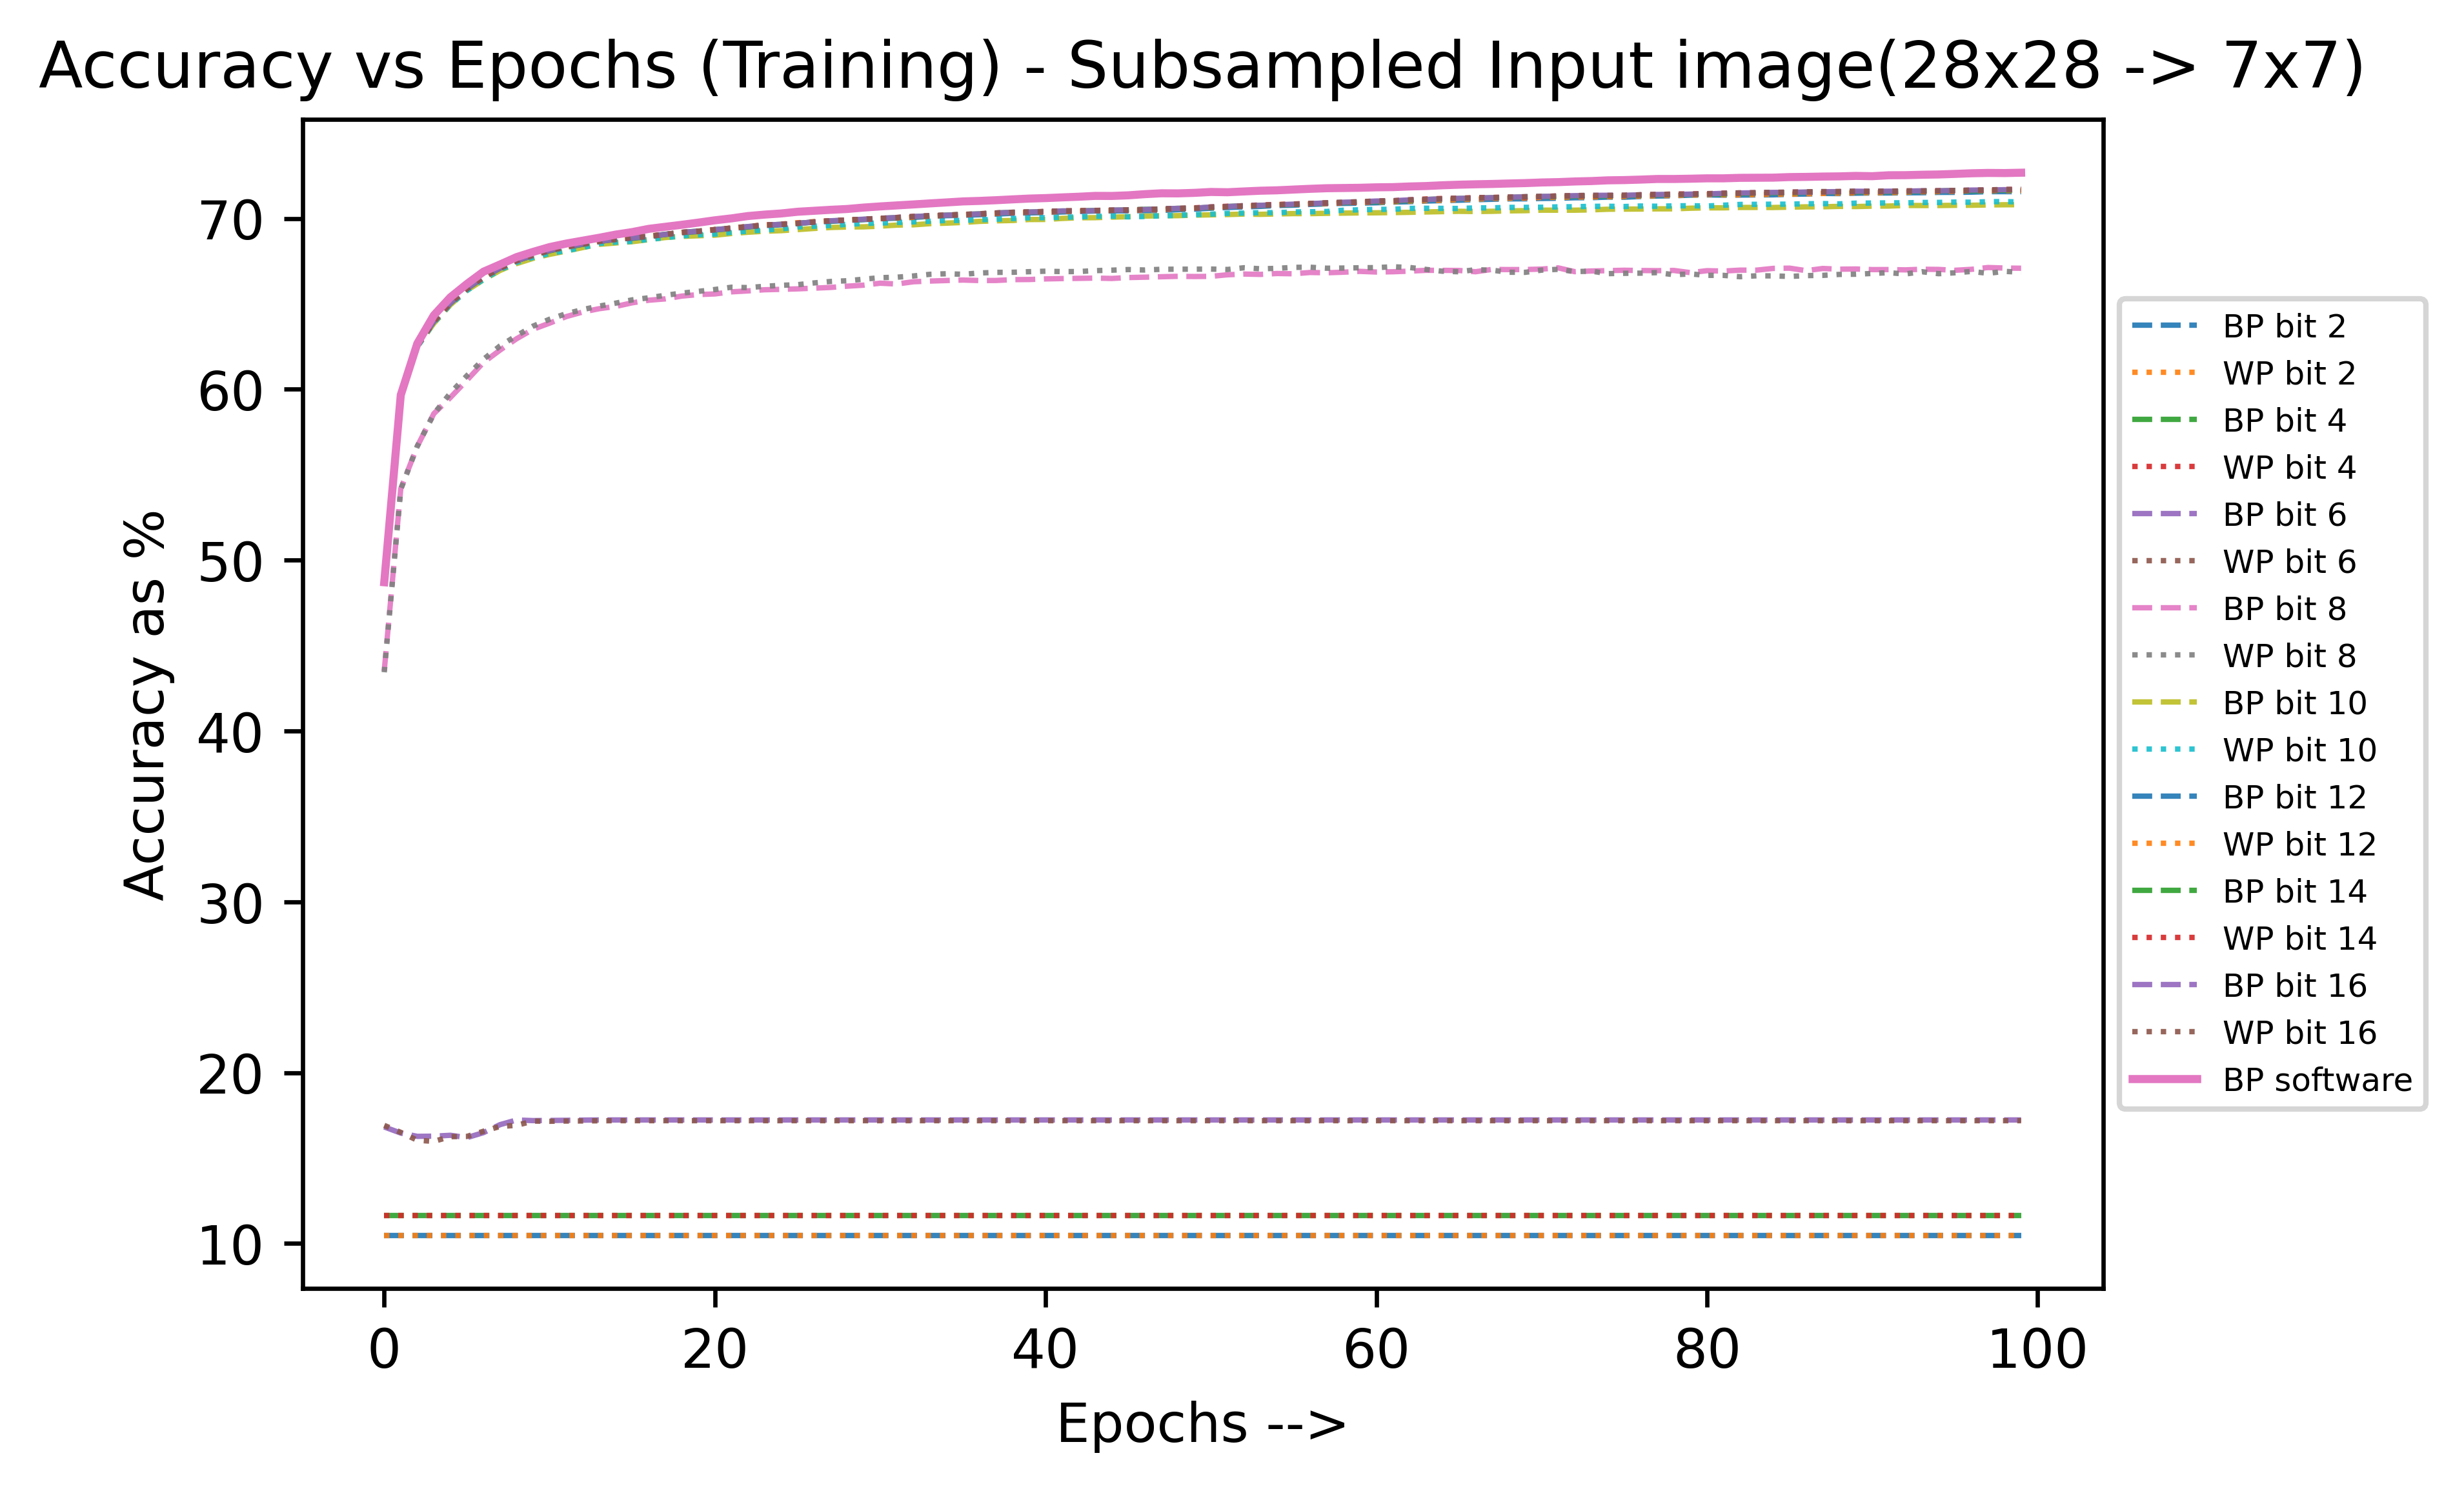

In [95]:
plt.rcParams['figure.dpi'] = 600
plt.figure()
k = 0
precisionList = [2,4,6,8,10, 12, 14, 16]
for acc in finTrainAcc:
    bpAcc = [acc[i][0] for i in range(0, len(acc))]
    wpAcc = [acc[i][1] for i in range(0, len(acc))]
    plt.plot(bpAcc, linewidth = 1, alpha = 0.9, linestyle = '--', label = f"BP bit {precisionList[k]}")
    plt.plot(wpAcc, linewidth = 1, alpha = 0.9, linestyle = ':',label =  f"WP bit {precisionList[k]}")
    k+=1
plt.plot(train_accBPSoftWare, label = "BP software")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 6)
plt.xlabel("Epochs -->")
plt.ylabel("Accuracy as %")
plt.title("Accuracy vs Epochs (Training) - Subsampled Input image(28x28 -> 7x7)")

Text(0.5, 1.0, 'Accuracy vs Epochs (Validation) - Subsampled Input image(28x28 -> 7x7)')

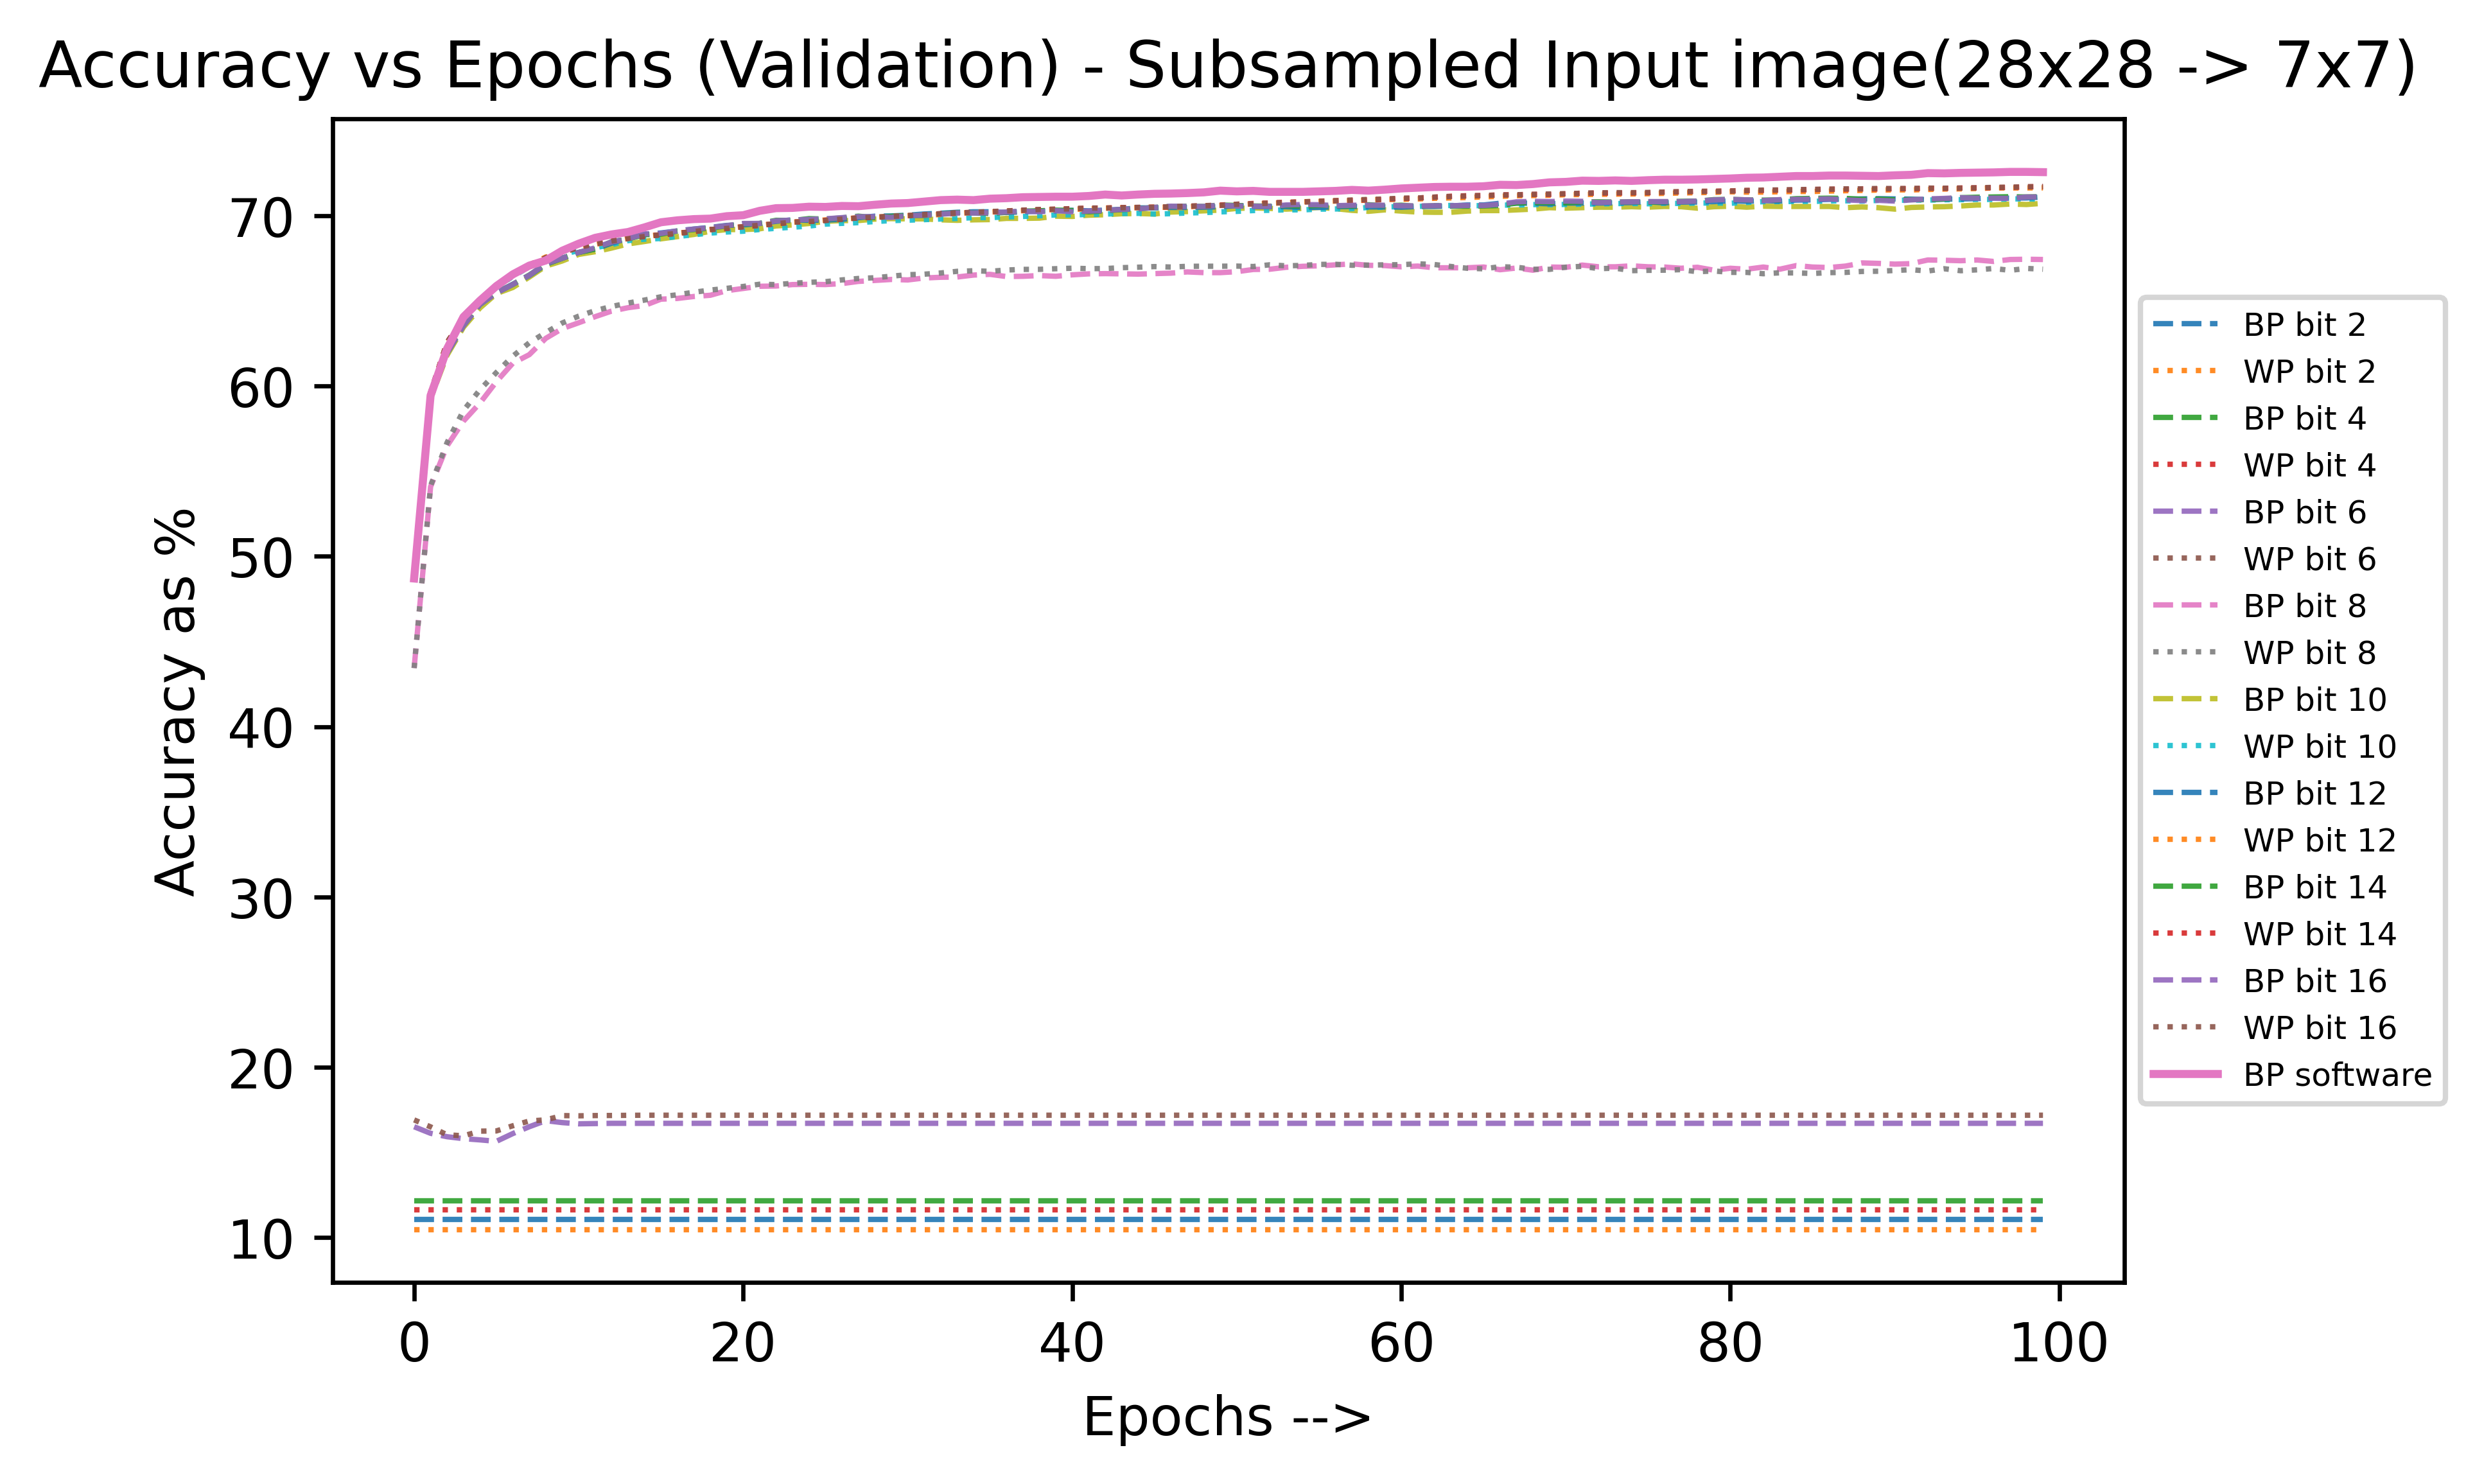

In [94]:
plt.rcParams['figure.dpi'] = 600
plt.figure()
k = 0
precisionList = [2,4,6,8,10, 12, 14, 16]
for acc in finValAcc:
    bpAcc = [acc[i][0] for i in range(0, len(acc))]
    wpAcc = [acc[i][1] for i in range(0, len(acc))]
    plt.plot(bpAcc, linewidth = 1, alpha = 0.9, linestyle = '--', label = f"BP bit {precisionList[k]}")
    plt.plot(wpAcc, linewidth = 1, alpha = 0.9, linestyle = ':',label =  f"WP bit {precisionList[k]}")
    k+=1
plt.plot(val_accBPSoftWare, label = "BP software")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 6)
plt.xlabel("Epochs -->")
plt.ylabel("Accuracy as %")
plt.title("Accuracy vs Epochs (Validation) - Subsampled Input image(28x28 -> 7x7)")

# Full input image training

In [100]:
def batch_grad_descentBPWPQuantCompFullImg(X,Y,iter, pert, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  #blind updates
  W1bp = W1.copy()
  b1bp = b1.copy()
  W2bp = W2.copy()
  b2bp = b2.copy()

  #variability aware updates
  W1wp = W1.copy()
  b1wp = b1.copy()
  W2wp = W2.copy()
  b2wp = b2.copy()

  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  # W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  # b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, k =onoff)
  # W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, k =onoff)
  # b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)



  # W1lookUp = createLookUpTable2d(W1, W1Currents, precision, step, discreteSteps, wRange)
  # b1lookUp = createLookUpTable2d(b1, b1Currents, precision, step, discreteSteps, wRange)
  # W2lookUp = createLookUpTable2d(W2, W2Currents, precision, step, discreteSteps, wRange)
  # b2lookUp = createLookUpTable2d(b2, b2Currents, precision, step, discreteSteps, wRange)

  W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
  b1bp = roundArbitrary(b1bp, step, wRange)
  W2bp = roundArbitrary(W2bp, step, wRange)
  b2bp = roundArbitrary(b2bp, step, wRange)

  W1wp = roundArbitrary(W1wp, step, wRange)#weights have to maintained as their digitized versions
  b1wp = roundArbitrary(b1wp, step, wRange)
  W2wp = roundArbitrary(W2wp, step, wRange)
  b2wp = roundArbitrary(b2wp, step, wRange)


  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
      # W1varoc = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1bp, b1bp, W2bp, b2bp) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1bp, W2bp, X1, Y1)


      #W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)
      #actualW1vaUpdate = W1varoc - weightTransformWithVariability(findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1), W1Currents, precision, step, discreteSteps, wRange)
      
      # W1bp = findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1)
      # b1bp = findNextState(disArr, b1lookUp, b1varoc.reshape((midLayerSize,1)) + (-1)*lr*db1.reshape((midLayerSize,1)))
      # W2bp = findNextState(disArr, W2lookUp, W2varoc + (-1)*lr*dW2)
      # b2bp = findNextState(disArr, b2lookUp, b2varoc.reshape((10,1)) + (-1)*lr*db2.reshape((10,1)))

      W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp,b2bp, dW1, db1, dW2, db2, lr = lr)

      W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
      b1bp = roundArbitrary(b1bp, step, wRange)
      W2bp = roundArbitrary(W2bp, step, wRange)
      b2bp = roundArbitrary(b2bp, step, wRange)
      


      #blind updates
      # W1varoc = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1wp, b1wp, W2wp, b2wp) 

      loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      #dW1, db1, dW2, db2 = WP(W1, b1, W2, b2, pert=pert, lossBeforePert=loss, X=X1, y=Y1)
      #dW1, db1, dW2, db2 = WPwithVarUp(W1wp, b1wp, W2wp, b2wp, pert, loss, X1, Y1, precision, step, discreteSteps, wRange,  W1varoc, b1varoc, W2varoc, b2varoc, W1Currents, b1Currents, W2Currents, b2Currents)

      dW1, db1, dW2, db2 = WP(W1wp, b1wp, W2wp, b2wp, pert, loss, X1, Y1)
      # W1wp = findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1)
      # b1wp = findNextState(disArr, b1lookUp, b1varoc.reshape((midLayerSize,1)) + (-1)*lr*db1.reshape((midLayerSize,1)))
      # W2wp = findNextState(disArr, W2lookUp, W2varoc + (-1)*lr*dW2)
      # b2wp = findNextState(disArr, b2lookUp, b2varoc.reshape((10,1)) + (-1)*lr*db2.reshape((10,1)))

      W1wp, b1wp, W2wp, b2wp = param_update(W1wp, b1wp, W2wp,b2wp, dW1, db1, dW2, db2, lr = lr)

      W1wp = roundArbitrary(W1wp, step, wRange)#weights have to maintained as their digitized versions
      b1wp = roundArbitrary(b1wp, step, wRange)
      W2wp = roundArbitrary(W2wp, step, wRange)
      b2wp = roundArbitrary(b2wp, step, wRange)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      # W1varoc = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1bp, b1bp, W2bp, b2bp)
      _, _, _,   A2_val = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      buAccTrainAcc = accuracy(predictions(A2_train), Y)
      buTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      buAccValAcc = accuracy(predictions(A2_val), y_val)
      buValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


      # W1varoc = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange)
      # b1varoc = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange)
      # W2varoc = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange)
      # b2varoc = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1wp, b1wp, W2wp, b2wp)
      _, _, _,   A2_val = forward(x_val, W1wp, b1wp, W2wp, b2wp)
      vaAccTrainAcc = accuracy(predictions(A2_train), Y)
      vaTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      vaAccValAcc = accuracy(predictions(A2_val), y_val)
      vaValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))
  
      train_acc.append([buAccTrainAcc, vaAccTrainAcc])
      print(f'Training :: BP : {buAccTrainAcc} :: WP : {vaAccTrainAcc}')


      val_acc.append([buAccValAcc, vaAccTrainAcc])
      print(f'Validation  :: BP : {buAccValAcc} :: WP : {vaAccValAcc} :: Blind Loss : {buValLoss} :: Val Loss : {vaValLoss}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [101]:
mu = 0.7
#sigma = 0.01
sigma = 0.000000000000000000001
onoff = 100000000000000000000000
vDD = 5
precision = 8#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10
lr = 0.1

In [102]:
finTrainAccFullImg = []
finValAccFullImg = []
for precision in [2,4,6,8,10, 12, 14, 16]:
    wRange = 1
    noOfLevels = 2**precision - 1 #no of levels of quantization
    #step = round(wRange/noOfLevels, precision)
    step =  wRange/noOfLevels#step size of each of the step after quantization
    #discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
    discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
    _, _, _, _, train_acc, val_acc, _, _, _ = batch_grad_descentBPWPQuantCompFullImg(x_train,y_train,iter, step, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = 47,print_op=1)
    finTrainAccFullImg.append(train_acc)
    finValAccFullImg.append(val_acc)

Params Initialised
Iteration: 1
Training :: BP : 18.825396825396826 :: WP : 14.157142857142857
Validation  :: BP : 18.6 :: WP : 14.257142857142856 :: Blind Loss : 19235.237010746143 :: Val Loss : 16806.39364710856
Iteration: 2
Training :: BP : 18.825396825396826 :: WP : 14.157142857142857
Validation  :: BP : 18.6 :: WP : 14.257142857142856 :: Blind Loss : 19235.237010746143 :: Val Loss : 16806.39364710856
Iteration: 3
Training :: BP : 18.825396825396826 :: WP : 14.157142857142857
Validation  :: BP : 18.6 :: WP : 14.257142857142856 :: Blind Loss : 19235.237010746143 :: Val Loss : 16806.39364710856
Iteration: 4
Training :: BP : 18.825396825396826 :: WP : 14.157142857142857
Validation  :: BP : 18.6 :: WP : 14.257142857142856 :: Blind Loss : 19235.237010746143 :: Val Loss : 16806.39364710856
Iteration: 5
Training :: BP : 18.825396825396826 :: WP : 14.157142857142857
Validation  :: BP : 18.6 :: WP : 14.257142857142856 :: Blind Loss : 19235.237010746143 :: Val Loss : 16806.39364710856
Iterat

In [103]:
finTrainAccFullImg

[[[18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142857142857],
  [18.825396825396826, 14.157142

Text(0.5, 1.0, 'Accuracy vs Epochs (Training) - Full Input image(28x28)')

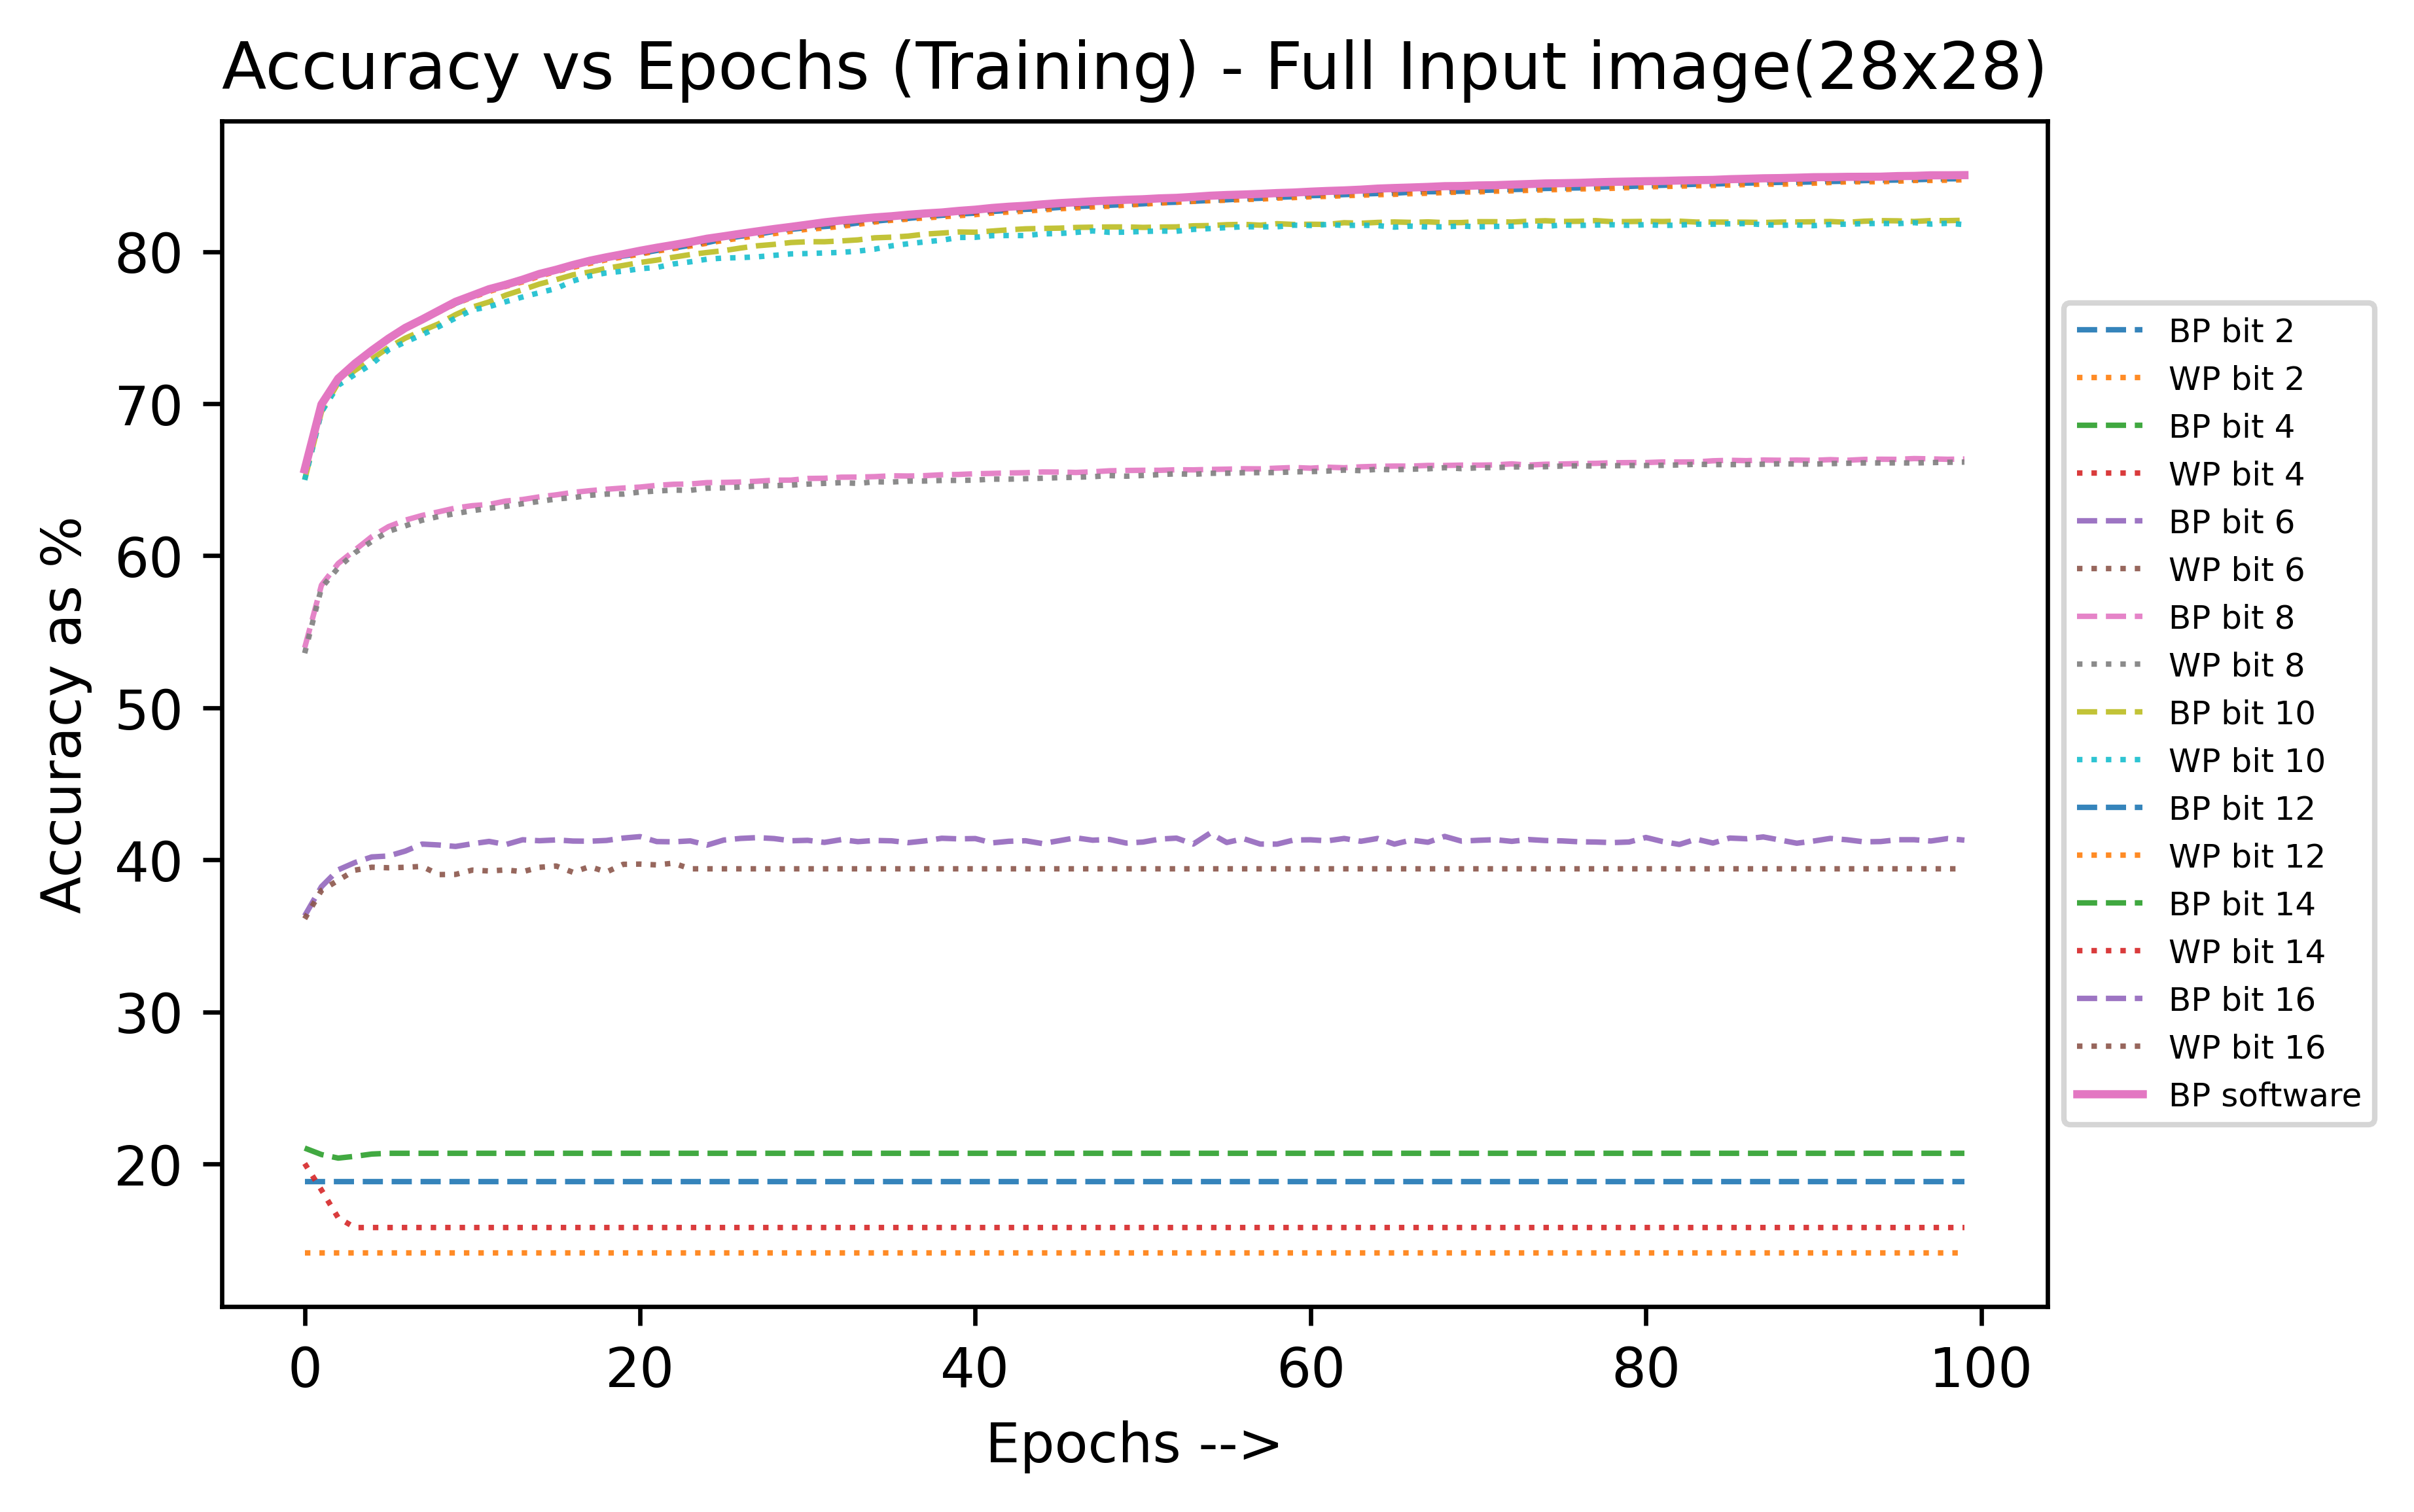

In [112]:
plt.rcParams['figure.dpi'] = 600
plt.figure()
k = 0
precisionList = [2,4,6,8,10, 12, 14, 16]
for acc in finTrainAccFullImg:
    bpAcc = [acc[i][0] for i in range(0, len(acc))]
    wpAcc = [acc[i][1] for i in range(0, len(acc))]
    plt.plot(bpAcc, linewidth = 1, alpha = 0.9, linestyle = '--', label = f"BP bit {precisionList[k]}")
    plt.plot(wpAcc, linewidth = 1, alpha = 0.9, linestyle = ':',label =  f"WP bit {precisionList[k]}")
    k+=1
plt.plot(train_accBPFullImg, label = "BP software")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 6)
plt.xlabel("Epochs -->")
plt.ylabel("Accuracy as %")
plt.title("Accuracy vs Epochs (Training) - Full Input image(28x28)")

Text(0.5, 1.0, 'Accuracy vs Epochs (Training) - Full Input image(28x28)')

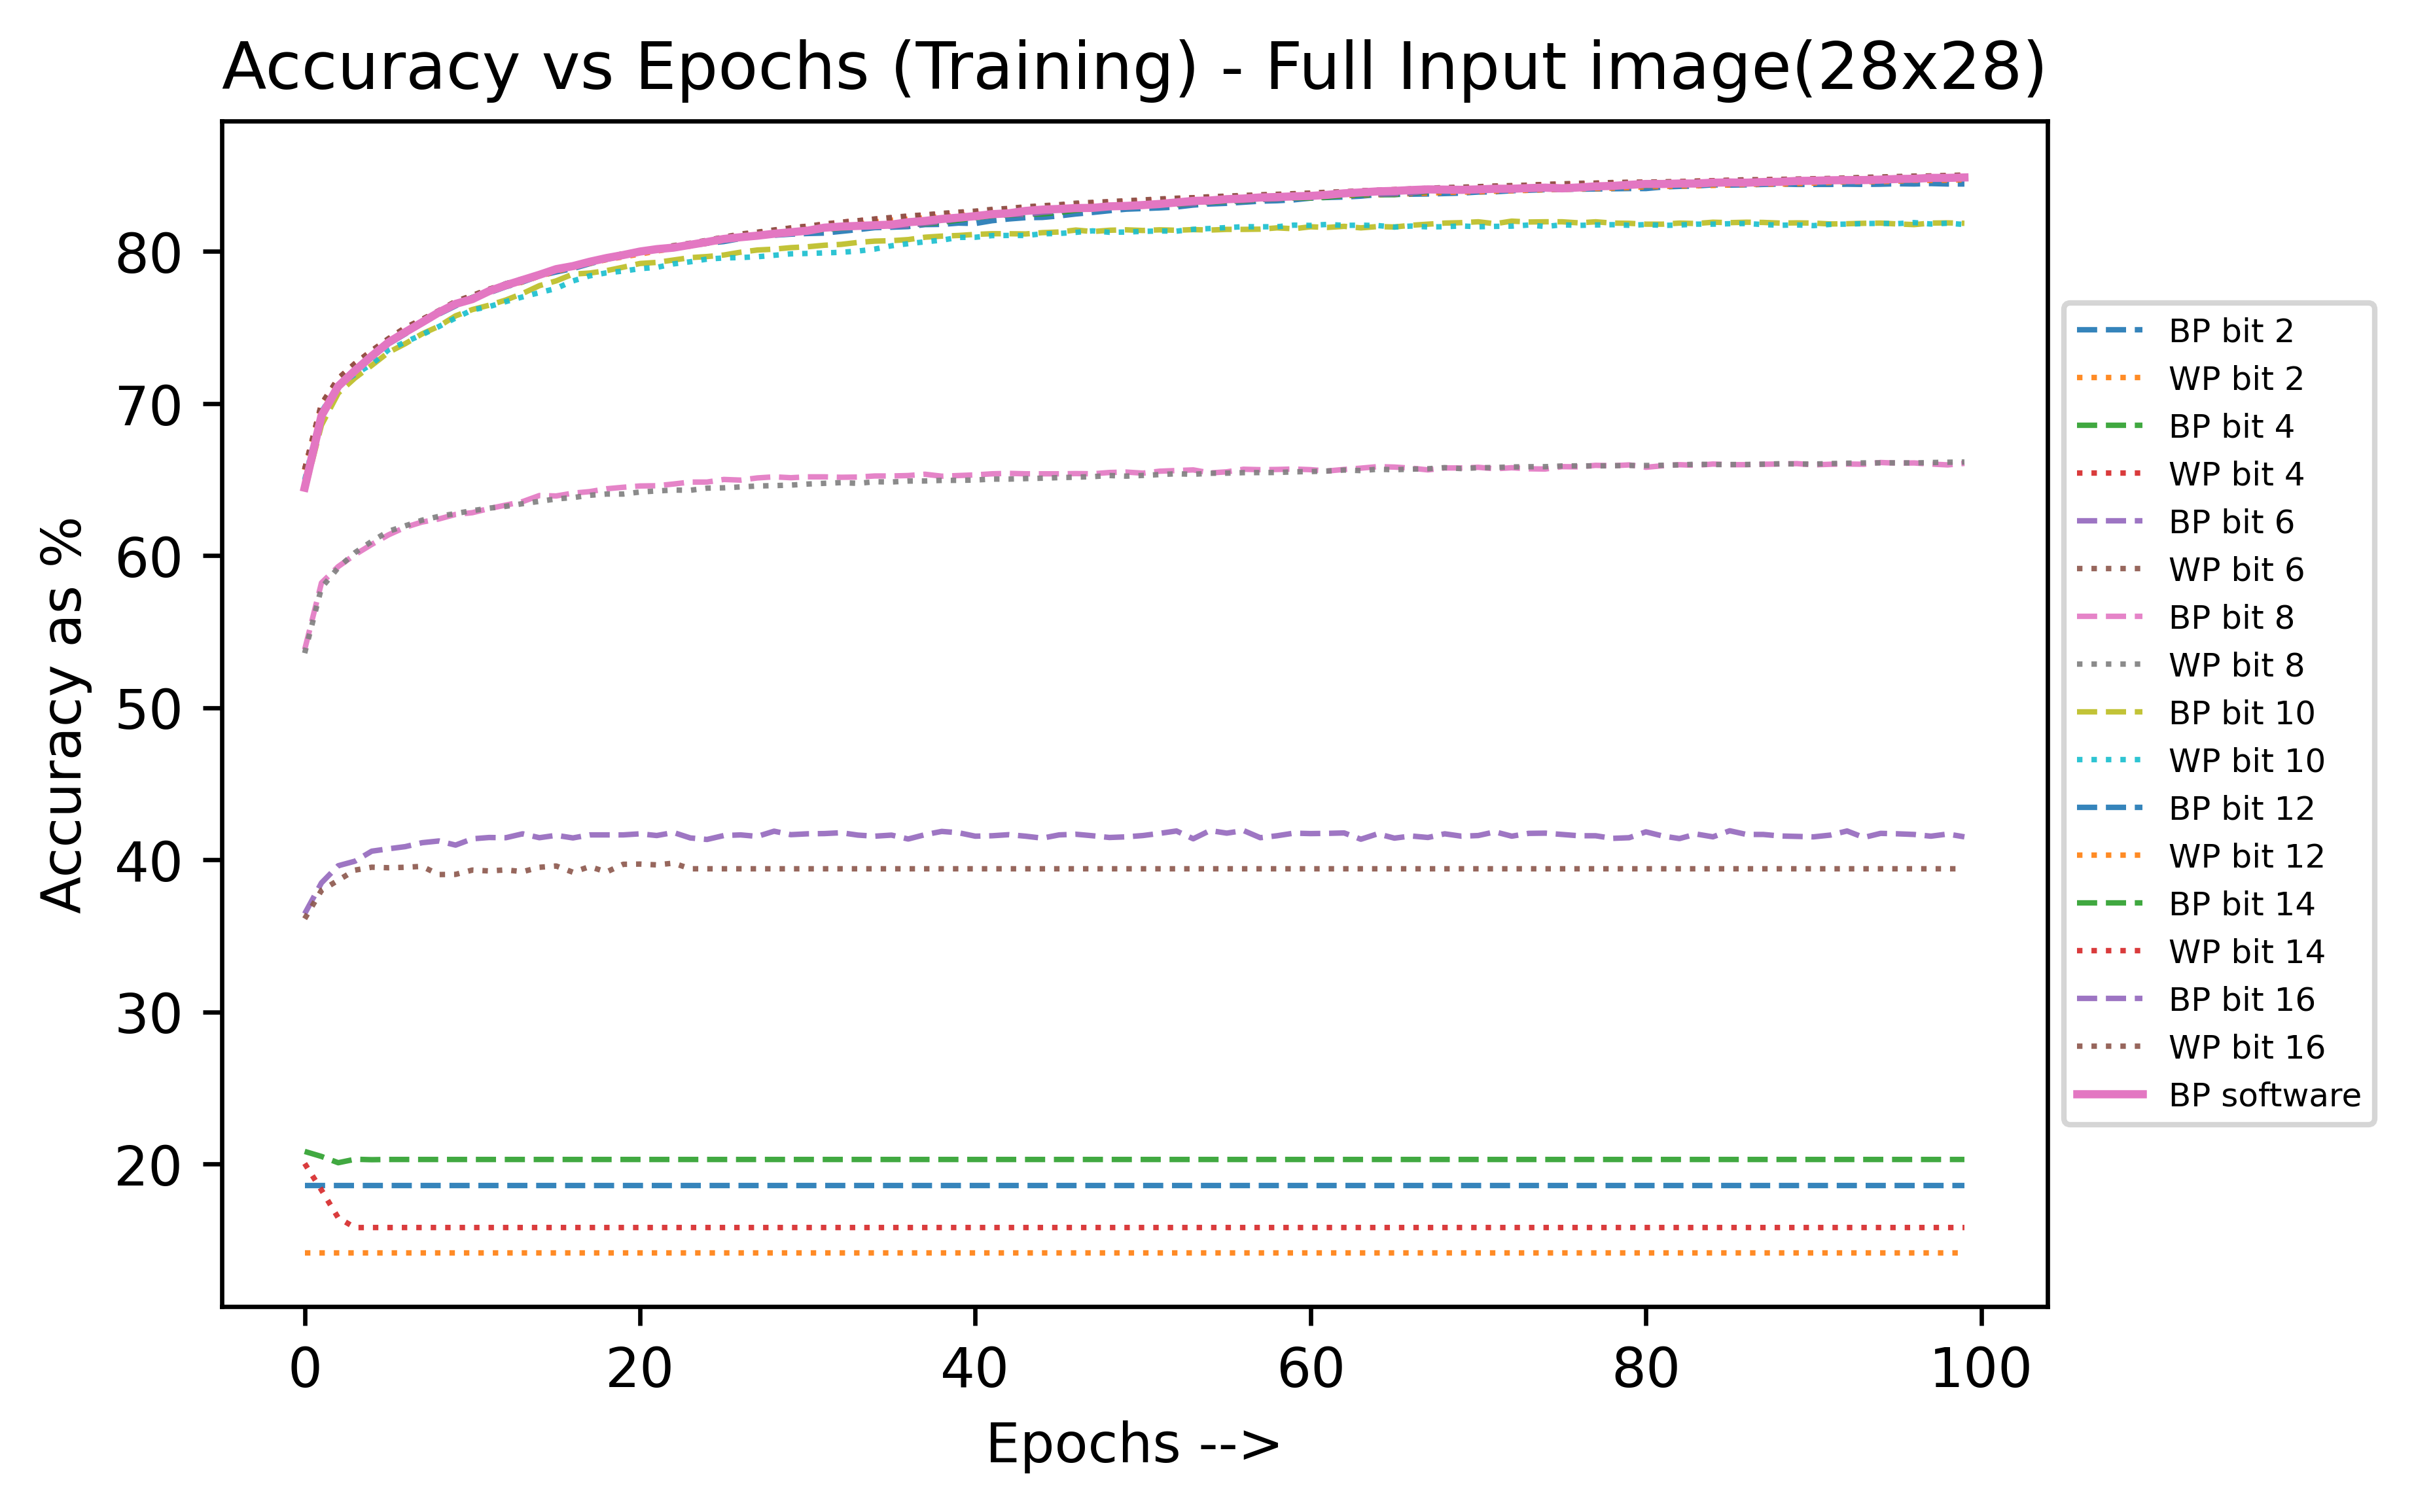

In [113]:
plt.rcParams['figure.dpi'] = 600
plt.figure()
k = 0
precisionList = [2,4,6,8,10, 12, 14, 16]
for acc in finValAccFullImg:
    bpAcc = [acc[i][0] for i in range(0, len(acc))]
    wpAcc = [acc[i][1] for i in range(0, len(acc))]
    plt.plot(bpAcc, linewidth = 1, alpha = 0.9, linestyle = '--', label = f"BP bit {precisionList[k]}")
    plt.plot(wpAcc, linewidth = 1, alpha = 0.9, linestyle = ':',label =  f"WP bit {precisionList[k]}")
    k+=1
plt.plot(val_accBPFullImg, label = "BP software")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 6)
plt.xlabel("Epochs -->")
plt.ylabel("Accuracy as %")
plt.title("Accuracy vs Epochs (Training) - Full Input image(28x28)")